In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import os
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, PrecisionRecallDisplay, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pu_loss import PULoss
from data_loader import *
from utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Prepare Data

In [2]:
DATA_DIR = os.path.join("data", "UCI HAR Dataset")
features_path = os.path.join(DATA_DIR, "features.txt")
features = pd.read_csv(features_path, sep='\s+', header=None, names=['index', 'feature_name'])['feature_name'].tolist()

X_train = pd.read_csv(
    os.path.join(DATA_DIR, "train", "X_train.txt"),
    sep='\s+',
    header=None,
)
X_test = pd.read_csv(
    os.path.join(DATA_DIR, "test", "X_test.txt"),
    sep='\s+',
    header=None,
)

y_train = pd.read_csv(
    os.path.join(DATA_DIR, "train", "y_train.txt"),
    header=None
)[0]
y_test = pd.read_csv(
    os.path.join(DATA_DIR, "test", "y_test.txt"),
    header=None
)[0]

In [3]:
pd.set_option('display.max_columns', None)
X_train.head()

0         1         2         3         4         5         6    \
0  0.288585 -0.020294 -0.132905 -0.995279 -0.983111 -0.913526 -0.995112   
1  0.278419 -0.016411 -0.123520 -0.998245 -0.975300 -0.960322 -0.998807   
2  0.279653 -0.019467 -0.113462 -0.995380 -0.967187 -0.978944 -0.996520   
3  0.279174 -0.026201 -0.123283 -0.996091 -0.983403 -0.990675 -0.997099   
4  0.276629 -0.016570 -0.115362 -0.998139 -0.980817 -0.990482 -0.998321   

        7         8         9         10        11        12        13   \
0 -0.983185 -0.923527 -0.934724 -0.567378 -0.744413  0.852947  0.685845   
1 -0.974914 -0.957686 -0.943068 -0.557851 -0.818409  0.849308  0.685845   
2 -0.963668 -0.977469 -0.938692 -0.557851 -0.818409  0.843609  0.682401   
3 -0.982750 -0.989302 -0.938692 -0.576159 -0.829711  0.843609  0.682401   
4 -0.979672 -0.990441 -0.942469 -0.569174 -0.824705  0.849095  0.683250   

        14        15        16        17        18        19        20   \
0  0.814263 -0.965523 -0.999945 -0.999863 -0.994612 -0.994231 -0.987614   
1  0.822637 -0.981930 -0.999991 -0.999788 -0.998405 -0.999150 -0.977866   
2  0.839344 -0.983478 -0.999969 -0.999660 -0.999470 -0.997130 -0.964810   
3  0.837869 -0.986093 -0.999976 -0.999736 -0.999504 -0.997180 -0.983799   
4  0.837869 -0.992653 -0.999991 -0.999856 -0.999757 -0.998004 -0.981232   

        21        22        23        24        25        26        27   \
0 -0.943220 -0.407747 -0.679338 -0.602122  0.929294 -0.853011  0.359910   
1 -0.948225 -0.714892 -0.500930 -0.570979  0.611627 -0.329549  0.284213   
2 -0.974675 -0.592235 -0.485821 -0.570979  0.273025 -0.086309  0.337202   
3 -0.986007 -0.627446 -0.850930 -0.911872  0.061436  0.074840  0.198204   
4 -0.991325 -0.786553 -0.559477 -0.761434  0.313276 -0.131208  0.191161   

        28        29        30        31        32        33        34   \
0 -0.058526  0.256892 -0.224848  0.264106 -0.095246  0.278851 -0.465085   
1  0.284595  0.115705 -0.090963  0.294310 -0.281211  0.085988 -0.022153   
2 -0.164739  0.017150 -0.074507  0.342256 -0.332564  0.239281 -0.136204   
3 -0.264307  0.072545 -0.155320  0.323154 -0.170813  0.294938 -0.306081   
4  0.086904  0.257615 -0.272505  0.434728 -0.315375  0.439744 -0.269069   

        35        36        37        38        39        40        41   \
0  0.491936 -0.190884  0.376314  0.435129  0.660790  0.963396 -0.140840   
1 -0.016657 -0.220643 -0.013429 -0.072692  0.579382  0.966561 -0.141551   
2  0.173863 -0.299493 -0.124698 -0.181105  0.608900  0.966878 -0.142010   
3  0.482148 -0.470129 -0.305693 -0.362654  0.507459  0.967615 -0.143976   
4  0.179414 -0.088952 -0.155804 -0.189763  0.599213  0.968224 -0.148750   

        42        43        44        45        46        47        48   \
0  0.115375 -0.985250 -0.981708 -0.877625 -0.985001 -0.984416 -0.894677   
1  0.109379 -0.997411 -0.989447 -0.931639 -0.997884 -0.989614 -0.933240   
2  0.101884 -0.999574 -0.992866 -0.992917 -0.999635 -0.992605 -0.992934   
3  0.099850 -0.996646 -0.981393 -0.978476 -0.996457 -0.980962 -0.978456   
4  0.094486 -0.998429 -0.988098 -0.978745 -0.998411 -0.988654 -0.978936   

        49        50        51        52        53        54        55   \
0  0.892055 -0.161265  0.124660  0.977436 -0.123213  0.056483 -0.375426   
1  0.892060 -0.161343  0.122586  0.984520 -0.114893  0.102764 -0.383430   
2  0.892401 -0.163711  0.094566  0.986770 -0.114893  0.102764 -0.401602   
3  0.893817 -0.163711  0.093425  0.986821 -0.121336  0.095753 -0.400278   
4  0.893817 -0.166786  0.091682  0.987434 -0.121834  0.094059 -0.400477   

        56        57        58        59        60        61   62   63   \
0  0.899469 -0.970905 -0.975510 -0.984325 -0.988849 -0.917743 -1.0 -1.0   
1  0.907829 -0.970583 -0.978500 -0.999188 -0.990029 -0.941685 -1.0 -1.0   
2  0.908668 -0.970368 -0.981672 -0.999679 -0.992104 -0.992619 -1.0 -1.0   
3  0.910621 -0.969400 -0.982420 -0.995976 -0.980663 -0.979779 -1.0 -1.0   
4  0.912235 -0.967051 -0.

In [4]:
y_train = y_train.to_numpy() - 1
y_test = y_test.to_numpy() - 1
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()


In [5]:
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, stratify=y_test, random_state=42
)

In [6]:
batch_size = 64
# Transform to binary 
positive_class = 2

y_train = np.where(y_train == positive_class, 1, 0)
y_val = np.where(y_val == positive_class, 1, 0)
y_test = np.where(y_test == positive_class, 1, 0)

X_train_tensor   = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor   = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

X_train_tensor = X_train_tensor.view(X_train_tensor.shape[0], 1, -1)
X_val_tensor = X_val_tensor.view(X_val_tensor.shape[0], 1, -1)
X_test_tensor = X_test_tensor.view(X_test_tensor.shape[0], 1, -1)
print(X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape)

train_dataset   = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset  = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader   = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # train 
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # test

torch.Size([7352, 1, 561]) torch.Size([1474, 1, 561]) torch.Size([1473, 1, 561])


In [7]:
print(f"Positive ratio in train: {y_train.sum()/y_train.shape[0]}") 
print(f"Positive ratio in val: {y_val.sum()/y_val.shape[0]}") 
print(f"Positive ratio in test: {y_test.sum()/y_test.shape[0]}") 

Positive ratio in train: 0.13411316648531013
Positive ratio in val: 0.14246947082767977
Positive ratio in test: 0.1425661914460285


In [8]:
unlabeled_fraction = 0.5
print(f"Positives before reduction, train: {y_train[y_train == 1].sum()}")
print(f"Positives before reduction, val: {y_val[y_val == 1].sum()}")
print(f"Positives before reduction, test: {y_test[y_test == 1].sum()}")

y_train_pu, unlabeled_idx_train = make_pu_labels(y_train, positive_class=1, unlabeled_fraction=unlabeled_fraction)
y_val_pu, unlabeled_idx_val = make_pu_labels(y_val, positive_class=1, unlabeled_fraction=unlabeled_fraction)
y_test_pu, unlabeled_idx_test = make_pu_labels(y_test, positive_class=1, unlabeled_fraction=unlabeled_fraction)

print(f"Positives after reduction, train: {y_train_pu[y_train_pu == 1].sum()}")
print(f"Positives after reduction, val: {y_val_pu[y_val_pu == 1].sum()}")
print(f"Positives after reduction, test: {y_test_pu[y_test_pu == 1].sum()}")


Positives before reduction, train: 986
Positives before reduction, val: 210
Positives before reduction, test: 210
Positives after reduction, train: 493
Positives after reduction, val: 105
Positives after reduction, test: 105


In [9]:
y_train_pu_tensor   = torch.tensor(y_train_pu, dtype=torch.long)
y_val_pu_tensor  = torch.tensor(y_val_pu, dtype=torch.long)
y_test_pu_tensor = torch.tensor(y_test_pu, dtype=torch.long)

train_dataset_pu   = TensorDataset(X_train_tensor, y_train_pu_tensor)
val_dataset_pu  = TensorDataset(X_val_tensor, y_val_pu_tensor)
test_dataset_pu = TensorDataset(X_test_tensor, y_test_pu_tensor)

train_loader_pu = DataLoader(train_dataset_pu, batch_size=batch_size, shuffle=True)
val_loader_pu   = DataLoader(val_dataset_pu, batch_size=batch_size, shuffle=False)
test_loader_pu  = DataLoader(test_dataset_pu, batch_size=batch_size, shuffle=False)


positive_prior = torch.tensor((y_train_pu).mean(), dtype=torch.float32)
positive_prior



tensor(0.0671)

# InceptionTime + AsymLoss (gamma=0.5)

In [11]:
from tsai.all import *
from pu_loss import PUAsymLoss_CE

criterion = PUAsymLoss_CE(gamma=0.5)


X_all = np.concatenate([X_train, X_val]).astype(np.float32)
y_all = np.concatenate([y_train_pu, y_val])

splits = (list(range(len(y_train_pu))),
         list(range(len(y_train_pu), len(y_all))))

tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)

clf = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus", arch_config=dict(fc_dropout=.3),
                   tfms=tfms, batch_tfms=batch_tfms,train_metrics=True, loss_func=criterion,
                   metrics=accuracy, cbs=ShowGraph(), wd=1e-3)


In [12]:
clf.load("har_inctime_asymloss_gamma_0.5")

In [13]:
X_all = X_all.reshape(X_all.shape[0], 1, X_all.shape[1])
X_all.shape


(8826, 1, 561)

In [14]:
# Train metrics

logits_train, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds_train = logits_train.argmax(dim=-1)
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9991    0.9998    0.9995      6366
           1     0.9990    0.9939    0.9964       986

    accuracy                         0.9990      7352
   macro avg     0.9990    0.9969    0.9979      7352
weighted avg     0.9990    0.9990    0.9990      7352

[[6365    1]
 [   6  980]]


In [15]:
logits_val, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds_val = logits_val.argmax(dim=-1)
print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9883    0.9984    0.9933      1264
           1     0.9898    0.9286    0.9582       210

    accuracy                         0.9885      1474
   macro avg     0.9891    0.9635    0.9758      1474
weighted avg     0.9885    0.9885    0.9883      1474

[[1262    2]
 [  15  195]]


In [16]:
logits_test, target = clf.get_X_preds(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]), y_test, with_decoded=False)
preds_test = logits_test.argmax(dim=-1)
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9867    1.0000    0.9933      1263
           1     1.0000    0.9190    0.9578       210

    accuracy                         0.9885      1473
   macro avg     0.9934    0.9595    0.9756      1473
weighted avg     0.9886    0.9885    0.9883      1473

[[1263    0]
 [  17  193]]


In [17]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of true positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of true positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of true positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")


Train
Total number of true positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 487
In percentage: 0.9878
Test
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 98
In percentage: 0.9333
Val
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 97
In percentage: 0.9238


## Calibration

In [10]:
from calibration import *
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import brier_score_loss
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
import torch, torch.nn.functional as F

In [19]:
y_prob_before = torch.softmax(torch.tensor(logits_test), dim=1).numpy()
n_bins = 10
y_prob_before

array([[9.9831307e-01, 1.6869925e-03],
       [9.9804085e-01, 1.9591798e-03],
       [9.9745315e-01, 2.5468147e-03],
       ...,
       [7.0765493e-03, 9.9292350e-01],
       [9.9786997e-01, 2.1299557e-03],
       [9.8624241e-06, 9.9999011e-01]], shape=(1473, 2), dtype=float32)

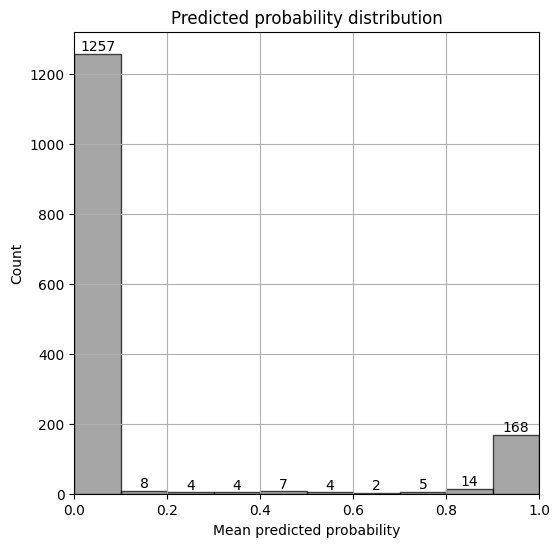

In [22]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(y_prob_before[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(y_prob_before[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

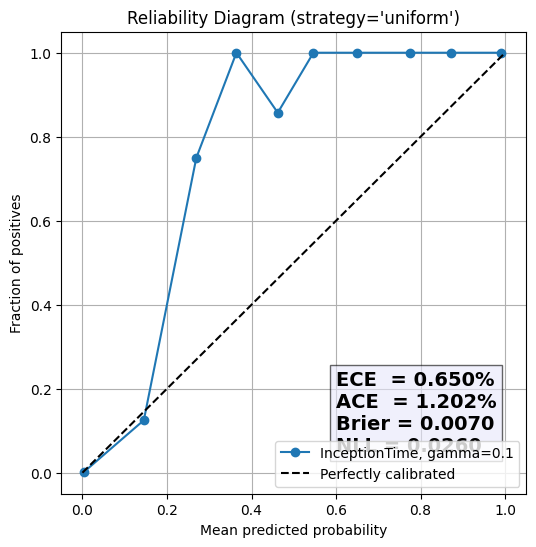

In [23]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_before, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_before[:, 1])
ace = adaptive_calibration_error(y_prob_before, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

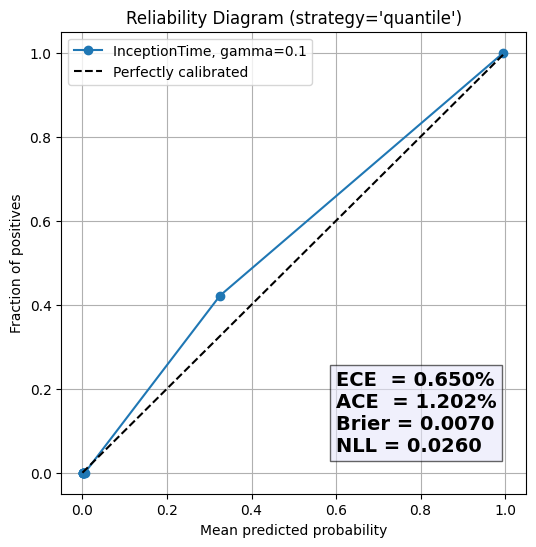

In [24]:
# strategy='quantile' = equal-mass binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

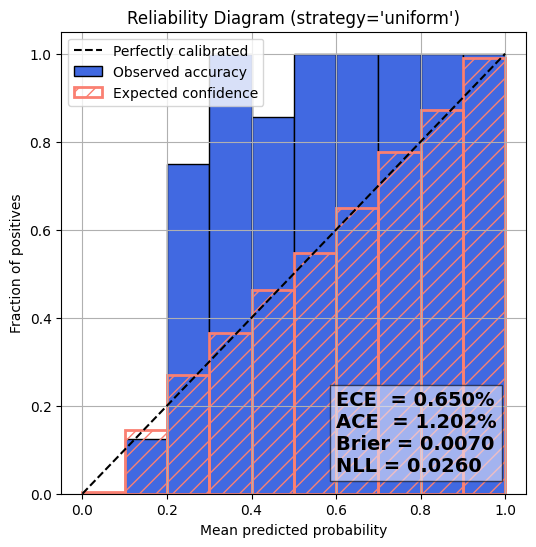

In [25]:
# equal-width binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# Let n_bins be the number of bins you want
n_bins = 10
bins = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# When plotting bars
bin_width = bins[1] - bins[0]

plt.figure(figsize=(6,6))
plt.bar(bin_centers, prob_true, width=bin_width, color='royalblue', edgecolor='black', align='center', label='Observed accuracy')
plt.bar(bin_centers, prob_pred, width=bin_width, fill=False, edgecolor='salmon', linewidth=2, hatch='//', align='center', label='Expected confidence')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid(True)
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

## Temperature Scaling

In [27]:
scaled_model = ModelWithTemperature(clf)
scaled_model.set_temperature(logits_val, y_all[splits[1]])

Optimal temperature: 0.845


ModelWithTemperature()

In [28]:
scaled_logits_test = scaled_model.temperature_scale(logits_test)
y_prob_after = torch.softmax(torch.tensor(scaled_logits_test), dim=1).numpy()

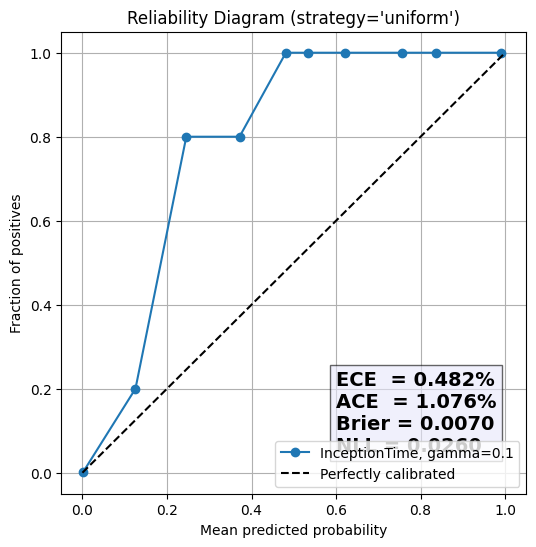

In [29]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_after, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_after[:, 1])
ace = adaptive_calibration_error(y_prob_after, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

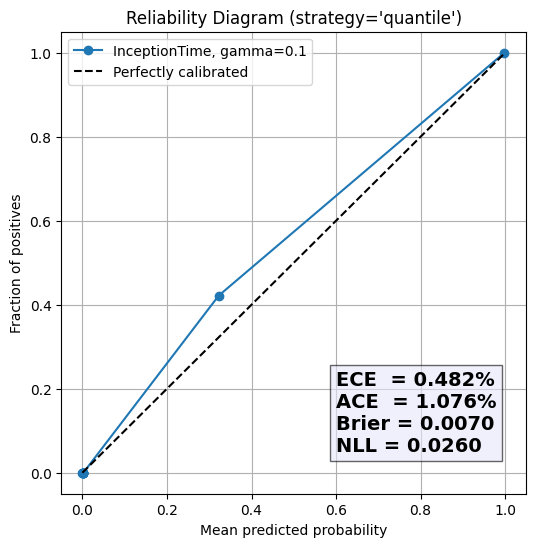

In [30]:
# strategy='quantile' -> equal-mass binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [31]:
ece, ece_rows = ece_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00482
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |     8 | [  0.500,   0.600] |      0.525  |      0.375 |       0.150  |     0.00081
 6  |     7 | [  0.600,   0.700] |      0.626  |      0.429 |       0.198  |     0.00094
 7  |     7 | [  0.700,   0.800] |      0.755  |      0.429 |       0.326  |     0.00155
 8  |    12 | [  0.800,   0.900] |      0.852  |      0.917 |       0.065  |     0.00053
 9  |  1439 | [  0.900,   1.000] |      0.997  |      0.998 |       0.001  |     0.00099


In [32]:
ace, ace_rows = ace_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.01076

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.00000, 0.01576] |    0.002   |   0.000  |    0.002
 1  |   148 | [0.01738, 0.99506] |    0.680   |   0.581  |    0.099
 2  |   148 | [0.99519, 0.99872] |    0.998   |   1.000  |    0.002
 3  |   148 | [0.99873, 0.99897] |    0.999   |   1.000  |    0.001
 4  |   148 | [0.99897, 0.99912] |    0.999   |   1.000  |    0.001
 5  |   148 | [0.99912, 0.99922] |    0.999   |   1.000  |    0.001
 6  |   148 | [0.99922, 0.99931] |    0.999   |   1.000  |    0.001
 7  |   148 | [0.99931, 0.99943] |    0.999   |   1.000  |    0.001
 8  |   148 | [0.99943, 0.99975] |    1.000   |   1.000  |    0.000
 9  |   141 | [0.99976, 0.99999] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Platt Scaling

In [33]:
s_val = logits_val[:, 1] - logits_val[:, 0]
s_test = logits_test[:, 1] - logits_test[:, 0]
lr = LogisticRegression(solver='lbfgs')
lr.fit(s_val.reshape(-1, 1), y_val)
calibrated_probs = lr.predict_proba(s_test.reshape(-1, 1))
calibrated_probs.shape

(1473, 2)

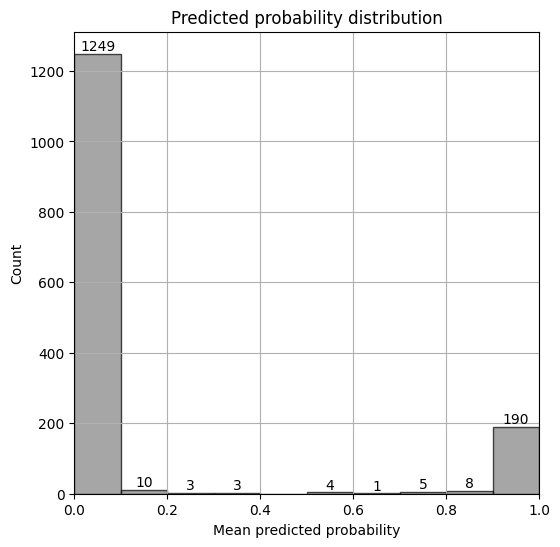

In [34]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(calibrated_probs[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(calibrated_probs[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

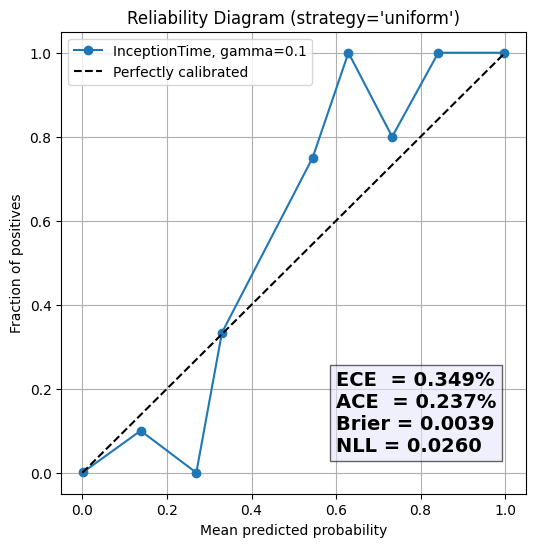

In [35]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, calibrated_probs[:, 1])
ace = adaptive_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

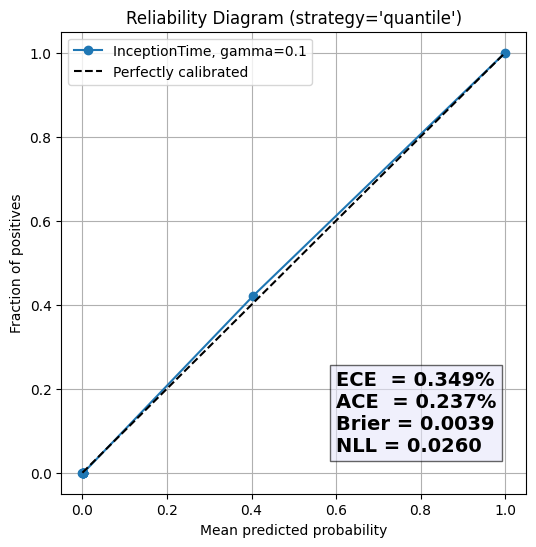

In [36]:
prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [37]:
ece, ece_rows = ece_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00349
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |     4 | [  0.500,   0.600] |      0.545  |      0.750 |       0.205  |     0.00056
 6  |     4 | [  0.600,   0.700] |      0.660  |      0.750 |       0.090  |     0.00025
 7  |     8 | [  0.700,   0.800] |      0.732  |      0.875 |       0.143  |     0.00078
 8  |    18 | [  0.800,   0.900] |      0.853  |      0.944 |       0.091  |     0.00112
 9  |  1439 | [  0.900,   1.000] |      0.998  |      0.999 |       0.001  |     0.00080


In [38]:
ace, ace_rows = ace_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00237

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.00000, 0.00099] |    0.000   |   0.000  |    0.000
 1  |   148 | [0.00112, 0.99363] |    0.598   |   0.581  |    0.017
 2  |   148 | [0.99384, 0.99885] |    0.998   |   1.000  |    0.002
 3  |   148 | [0.99886, 0.99913] |    0.999   |   1.000  |    0.001
 4  |   148 | [0.99913, 0.99928] |    0.999   |   1.000  |    0.001
 5  |   148 | [0.99928, 0.99939] |    0.999   |   1.000  |    0.001
 6  |   148 | [0.99939, 0.99948] |    0.999   |   1.000  |    0.001
 7  |   148 | [0.99948, 0.99959] |    1.000   |   1.000  |    0.000
 8  |   148 | [0.99959, 0.99986] |    1.000   |   1.000  |    0.000
 9  |   141 | [0.99986, 1.00000] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Isotonic Regression

In [39]:
p_val = torch.softmax(logits_val, dim=1).detach().cpu().numpy()[:, 1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_val, y_val)

p_test = torch.softmax(logits_test, dim=1).detach().cpu().numpy()[:, 1]
p_test_cal = iso.transform(p_test)
p_test_calibrated = np.column_stack([1 - p_test_cal, p_test_cal])  


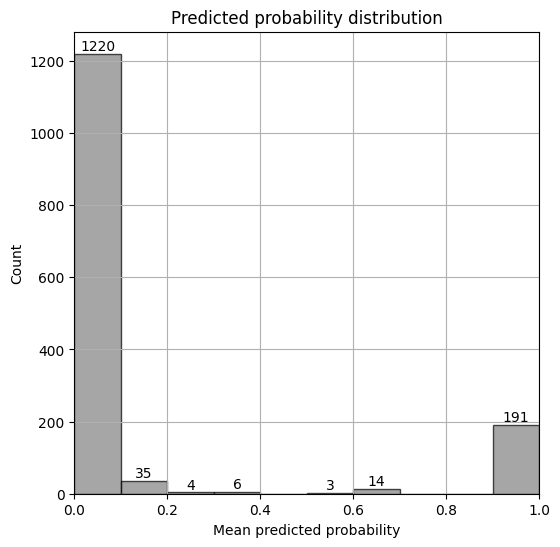

In [40]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(p_test_calibrated[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(p_test_calibrated[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

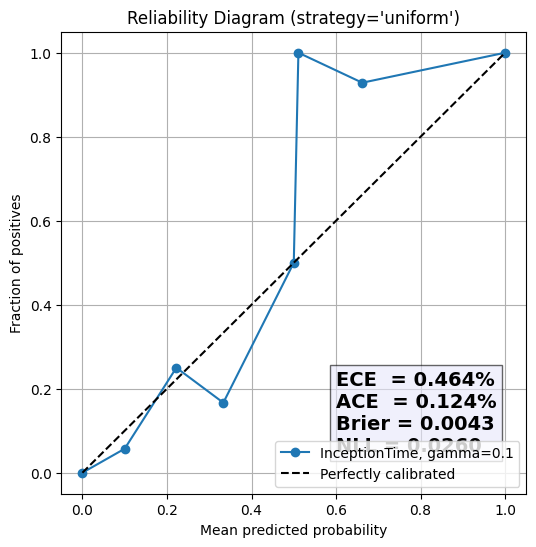

In [41]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, p_test_calibrated[:, 1])
ace = adaptive_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='uniform')
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

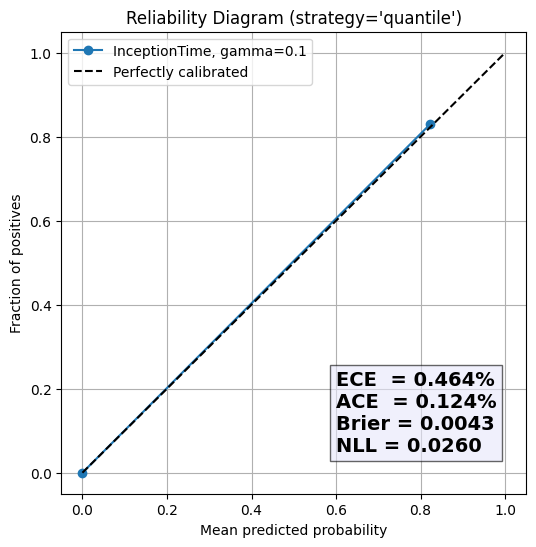

In [42]:
prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [43]:
ece, ece_rows = ece_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00464
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 4  |     2 | [  0.400,   0.500] |      0.500  |      0.500 |       0.000  |     0.00000
 5  |     1 | [  0.500,   0.600] |      0.511  |      1.000 |       0.489  |     0.00033
 6  |    20 | [  0.600,   0.700] |      0.663  |      0.900 |       0.237  |     0.00321
 7  |     4 | [  0.700,   0.800] |      0.778  |      0.750 |       0.028  |     0.00008
 8  |    35 | [  0.800,   0.900] |      0.900  |      0.943 |       0.043  |     0.00102
 9  |  1411 | [  0.900,   1.000] |      1.000  |      1.000 |       0.000  |     0.00000


In [44]:
ace, ace_rows = ace_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00124

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.00000, 0.00000] |    0.000   |   0.000  |    0.000
 1  |   148 | [0.00000, 1.00000] |    0.593   |   0.581  |    0.012
 2  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 3  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 4  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 5  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 6  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 7  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 8  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 9  |   141 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

# Mamba2 + AsymLoss (gamma = 0.1)

In [11]:
batch_size = 128
# X_train_tensor = X_train_tensor.unsqueeze(1)
# X_val_tensor = X_val_tensor.unsqueeze(1)
# X_test_tensor = X_test_tensor.unsqueeze(1)
print(X_train_tensor.shape)
train_dataset = TensorDataset(X_train_tensor, y_train_pu_tensor)
val_dataset = TensorDataset(X_val_tensor, torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

in_channel = X_train_tensor.shape[1]
seq_length = X_train_tensor.shape[2]
n_output = len(y_train_pu_tensor.unique())
print(f'in_channel: {in_channel}, sequence_length: {seq_length}, n_output: {n_output}')
n_hidden = 64
num_epochs = 15
lr = 0.0001

torch.Size([7352, 1, 561])
in_channel: 1, sequence_length: 561, n_output: 2


In [46]:
from baseline import Mamba2Classifier
print(X_train_tensor.shape)

torch.Size([7352, 1, 561])


In [47]:
model_mamba = Mamba2Classifier(in_channel, hidden_dim=256, num_classes=2, num_layers=2, dropout=0.5)
model_mamba = model_mamba.to(device)
print(model_mamba)

256 2 64
256 2 64
Mamba2Classifier(
  (input_proj): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (input_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, out_features=256, bias=False)
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, ou

In [48]:
model_mamba.load_state_dict(torch.load("models/har_mamba2_convproj_AsymLoss_0.1.pth", weights_only=True))

<All keys matched successfully>

In [49]:
X_test_tensor_perm = X_test_tensor.permute(0, 2, 1)
test_dataset = TensorDataset(X_test_tensor_perm, torch.tensor(y_test_pu, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=64)  

X_val_tensor_perm = X_val_tensor.permute(0, 2, 1)
val_dataset = TensorDataset(X_val_tensor_perm, torch.tensor(y_val_pu, dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=64)  

X_train_tensor_perm = X_train_tensor.permute(0, 2, 1)
train_dataset = TensorDataset(X_train_tensor_perm, torch.tensor(y_train_pu, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64)  
print(X_test_tensor_perm.shape)
print(X_val_tensor_perm.shape)
print(X_train_tensor_perm.shape)

torch.Size([1473, 561, 1])
torch.Size([1474, 561, 1])
torch.Size([7352, 561, 1])


In [50]:
preds_train = []
logits_train = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_train.append(preds.cpu())
        logits_train.append(outputs.cpu().detach())

# Concatenate all predictions
preds_train = torch.cat(preds_train).numpy()
logits_train = torch.cat(logits_train, dim=0)

print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9961    0.9920    0.9940      6366
           1     0.9496    0.9746    0.9620       986

    accuracy                         0.9897      7352
   macro avg     0.9728    0.9833    0.9780      7352
weighted avg     0.9898    0.9897    0.9897      7352

[[6315   51]
 [  25  961]]


In [51]:
preds_val = []
logits_val = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in val_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_val.append(preds.cpu())
        logits_val.append(outputs.cpu().detach())

# Concatenate all predictions
preds_val = torch.cat(preds_val).numpy()
logits_val = torch.cat(logits_val)

print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9803    0.9866    0.9834      1264
           1     0.9158    0.8810    0.8981       210

    accuracy                         0.9715      1474
   macro avg     0.9481    0.9338    0.9407      1474
weighted avg     0.9712    0.9715    0.9713      1474

[[1247   17]
 [  25  185]]


In [52]:
preds_test = []
logits_test = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_test.append(preds.cpu())
        logits_test.append(outputs.cpu().detach())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()
logits_test = torch.cat(logits_test)

print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9804    0.9889    0.9846      1263
           1     0.9296    0.8810    0.9046       210

    accuracy                         0.9735      1473
   macro avg     0.9550    0.9349    0.9446      1473
weighted avg     0.9731    0.9735    0.9732      1473

[[1249   14]
 [  25  185]]


In [53]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")


Train
Total number of positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 470
In percentage: 0.9533
Val
Total number of positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 94
In percentage: 0.8952
Test
Total number of positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 93
In percentage: 0.8857


## Calibration

In [54]:
y_prob_before = torch.softmax(torch.tensor(logits_test), dim=1).numpy()
n_bins = 10
y_prob_before

array([[9.9999928e-01, 7.0334903e-07],
       [9.9417168e-01, 5.8282642e-03],
       [9.9999988e-01, 1.0612186e-07],
       ...,
       [1.0170778e-03, 9.9898285e-01],
       [9.9992251e-01, 7.7449055e-05],
       [4.6281843e-03, 9.9537176e-01]], shape=(1473, 2), dtype=float32)

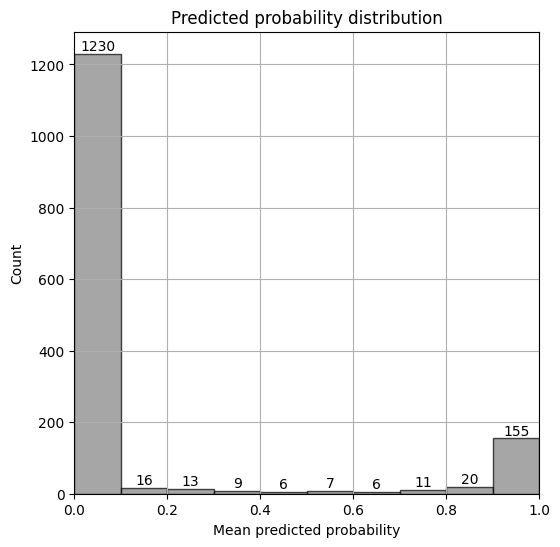

In [55]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(y_prob_before[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(y_prob_before[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

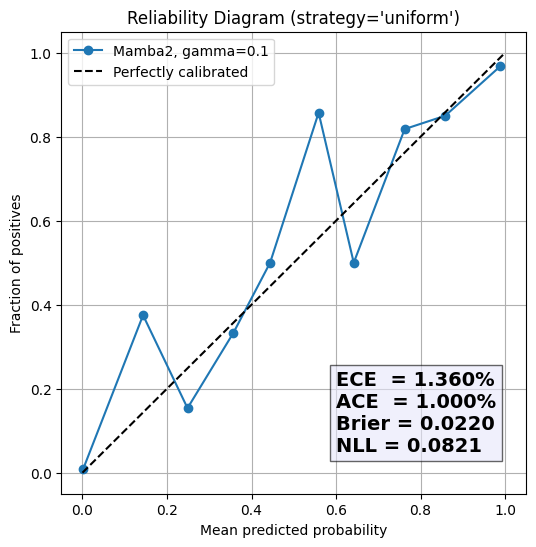

In [56]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_before, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_before[:, 1])
ace = adaptive_calibration_error(y_prob_before, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

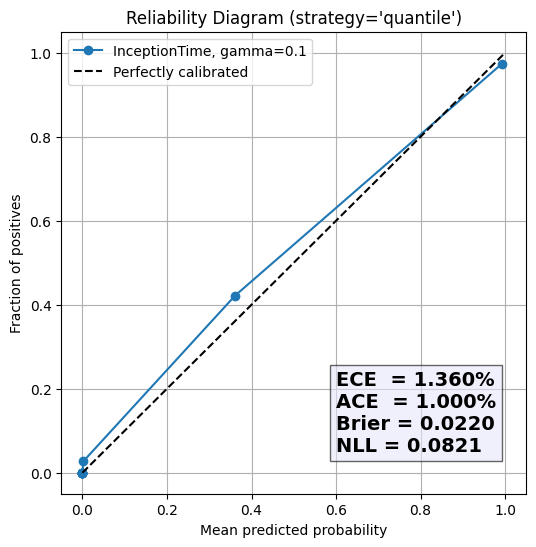

In [57]:
# strategy='quantile' = equal-mass binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

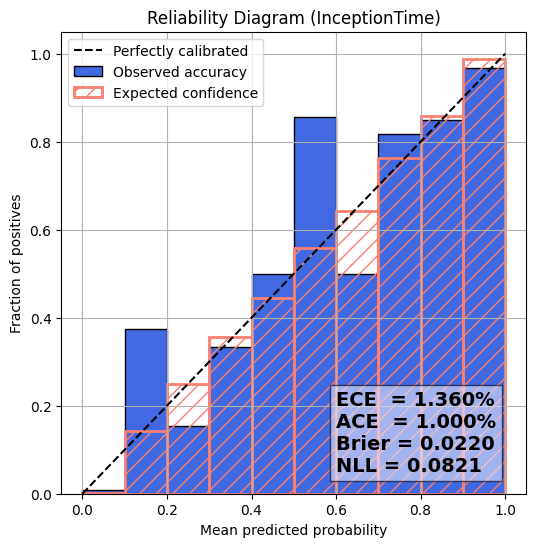

In [58]:
# equal-width binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# Let n_bins be the number of bins you want
n_bins = 10
bins = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# When plotting bars
bin_width = bins[1] - bins[0]

plt.figure(figsize=(6,6))
plt.bar(bin_centers, prob_true, width=bin_width, color='royalblue', edgecolor='black', align='center', label='Observed accuracy')
plt.bar(bin_centers, prob_pred, width=bin_width, fill=False, edgecolor='salmon', linewidth=2, hatch='//', align='center', label='Expected confidence')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (InceptionTime)')
plt.legend()
plt.grid(True)
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

## Temperature Scaling

In [59]:
scaled_model = ModelWithTemperature(model_mamba)
scaled_model.set_temperature(logits_val, y_val)

Optimal temperature: 1.695


ModelWithTemperature(
  (model): Mamba2Classifier(
    (input_proj): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (input_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (blocks): Sequential(
      (0): Mamba2Block(
        (mamba): Mamba2(
          (in_proj): Linear(in_features=256, out_features=1288, bias=False)
          (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
          (act): SiLU()
          (norm): RMSNorm()
          (out_proj): Linear(in_features=512, out_features=256, bias=False)
        )
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.5, inplace=False)
      )
      (1): Mamba2Block(
        (mamba): Mamba2(
          (in_proj): Linear(in_features=256, out_features=1288, bias=False)
          (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
          (act): SiLU()
          (norm): R

In [60]:
scaled_logits_test = scaled_model.temperature_scale(logits_test)
y_prob_after = torch.softmax(torch.tensor(scaled_logits_test), dim=1).numpy()

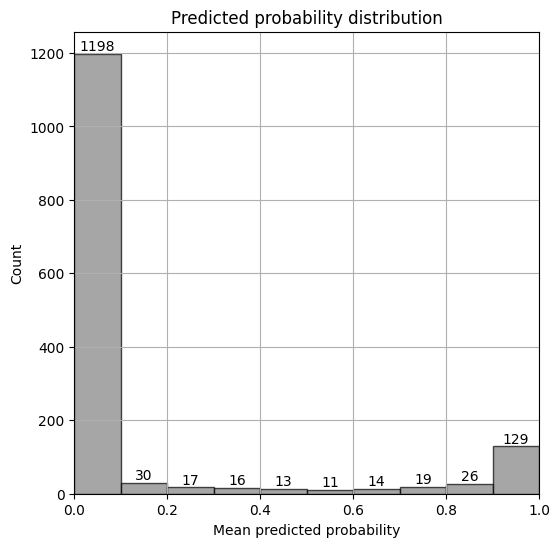

In [61]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(y_prob_after[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(y_prob_after[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

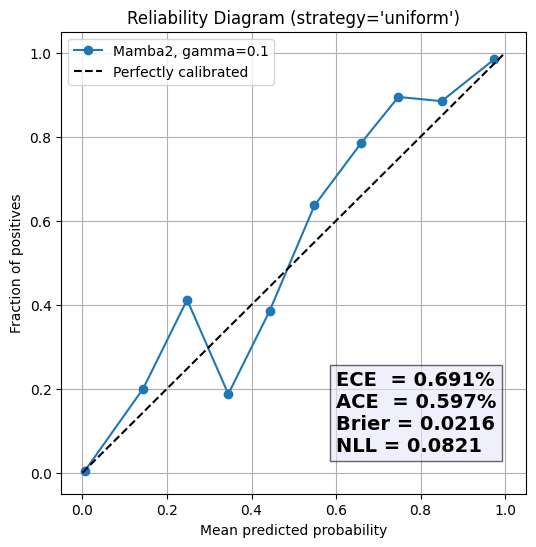

In [62]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_after, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_after[:, 1])
ace = adaptive_calibration_error(y_prob_after, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

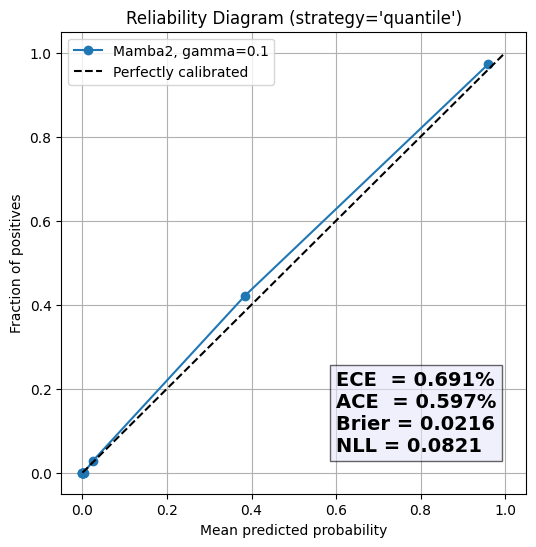

In [63]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [64]:
ece, ece_rows = ece_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00691
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    24 | [  0.500,   0.600] |      0.554  |      0.625 |       0.071  |     0.00116
 6  |    30 | [  0.600,   0.700] |      0.657  |      0.800 |       0.143  |     0.00291
 7  |    36 | [  0.700,   0.800] |      0.750  |      0.750 |       0.000  |     0.00001
 8  |    56 | [  0.800,   0.900] |      0.853  |      0.839 |       0.014  |     0.00053
 9  |  1327 | [  0.900,   1.000] |      0.993  |      0.995 |       0.003  |     0.00230


In [65]:
ace, ace_rows = ace_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00597

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.00016, 0.17348] |    0.040   |   0.027  |    0.013
 1  |   148 | [0.18592, 0.93439] |    0.617   |   0.581  |    0.036
 2  |   148 | [0.93704, 0.99224] |    0.977   |   0.973  |    0.004
 3  |   148 | [0.99233, 0.99785] |    0.996   |   1.000  |    0.004
 4  |   148 | [0.99785, 0.99916] |    0.999   |   1.000  |    0.001
 5  |   148 | [0.99917, 0.99961] |    0.999   |   1.000  |    0.001
 6  |   148 | [0.99961, 0.99982] |    1.000   |   1.000  |    0.000
 7  |   148 | [0.99982, 0.99992] |    1.000   |   1.000  |    0.000
 8  |   148 | [0.99992, 0.99997] |    1.000   |   1.000  |    0.000
 9  |   141 | [0.99997, 1.00000] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Platt Scaling

In [66]:
from sklearn.linear_model import LogisticRegression
s_val = logits_val[:, 1] - logits_val[:, 0]
s_test = logits_test[:, 1] - logits_test[:, 0]
lr = LogisticRegression(solver='lbfgs')
lr.fit(s_val.reshape(-1, 1), y_val)
calibrated_probs = lr.predict_proba(s_test.reshape(-1, 1))
calibrated_probs.shape

(1473, 2)

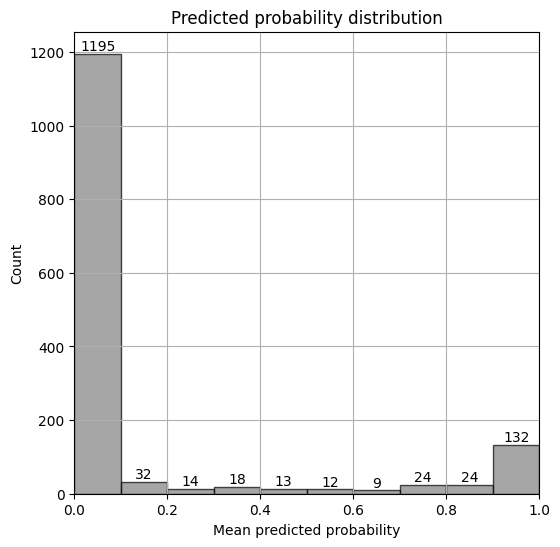

In [67]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(calibrated_probs[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(calibrated_probs[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

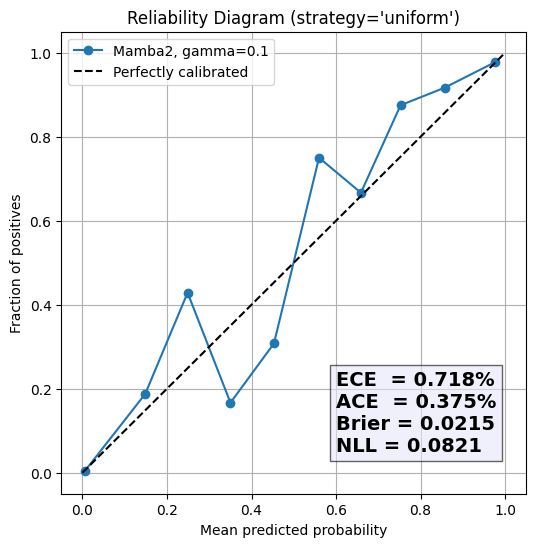

In [68]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, calibrated_probs[:, 1])
ace = adaptive_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

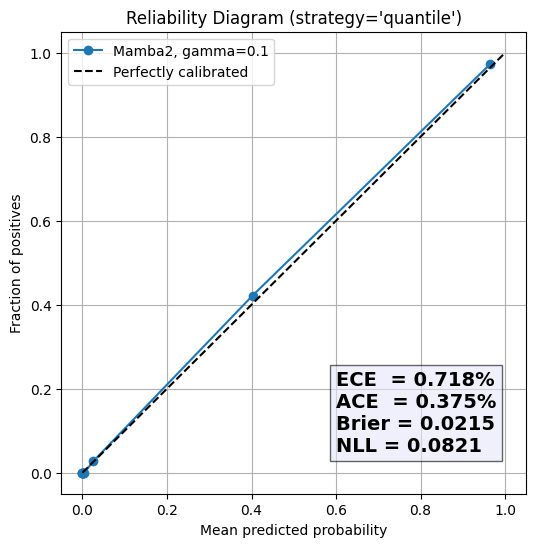

In [69]:
prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [70]:
ece, ece_rows = ece_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00718
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    25 | [  0.500,   0.600] |      0.553  |      0.720 |       0.167  |     0.00283
 6  |    27 | [  0.600,   0.700] |      0.653  |      0.778 |       0.125  |     0.00229
 7  |    38 | [  0.700,   0.800] |      0.752  |      0.763 |       0.011  |     0.00029
 8  |    56 | [  0.800,   0.900] |      0.854  |      0.857 |       0.003  |     0.00013
 9  |  1327 | [  0.900,   1.000] |      0.993  |      0.995 |       0.002  |     0.00164


In [71]:
ace, ace_rows = ace_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00375

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.00013, 0.15730] |    0.035   |   0.027  |    0.008
 1  |   148 | [0.16891, 0.92918] |    0.600   |   0.581  |    0.019
 2  |   148 | [0.93205, 0.99174] |    0.975   |   0.973  |    0.002
 3  |   148 | [0.99183, 0.99773] |    0.996   |   1.000  |    0.004
 4  |   148 | [0.99773, 0.99912] |    0.999   |   1.000  |    0.001
 5  |   148 | [0.99913, 0.99959] |    0.999   |   1.000  |    0.001
 6  |   148 | [0.99959, 0.99981] |    1.000   |   1.000  |    0.000
 7  |   148 | [0.99982, 0.99992] |    1.000   |   1.000  |    0.000
 8  |   148 | [0.99992, 0.99997] |    1.000   |   1.000  |    0.000
 9  |   141 | [0.99997, 1.00000] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Isotonic Regression

In [44]:
p_val = torch.softmax(logits_val, dim=1).detach().cpu().numpy()[:, 1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_val, y_val)

p_test = torch.softmax(logits_test, dim=1).detach().cpu().numpy()[:, 1]
p_test_cal = iso.transform(p_test)
p_test_calibrated = np.column_stack([1 - p_test_cal, p_test_cal])  


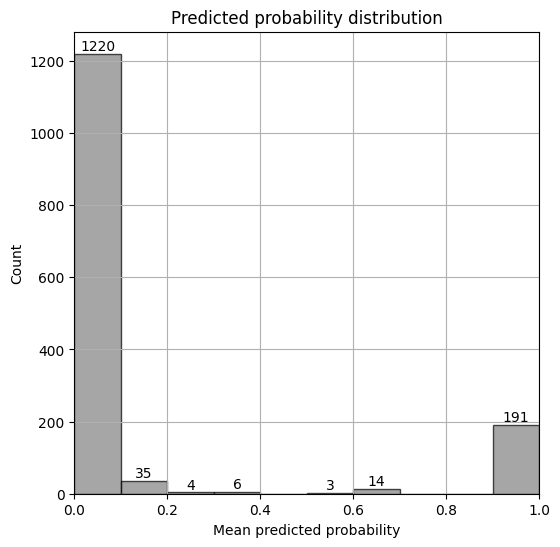

In [72]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(p_test_calibrated[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(p_test_calibrated[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

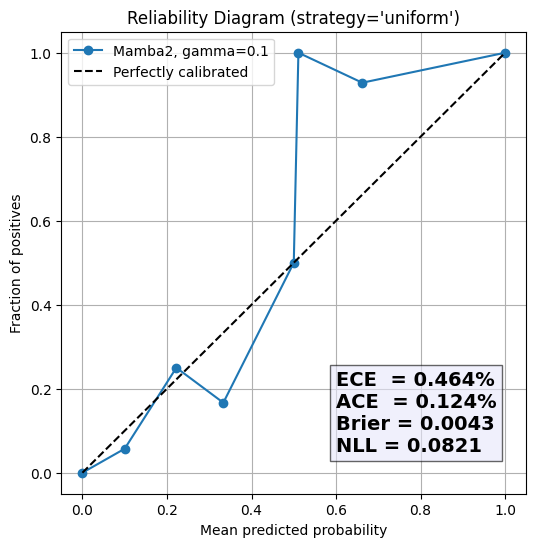

In [73]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, p_test_calibrated[:, 1])
ace = adaptive_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='uniform')
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

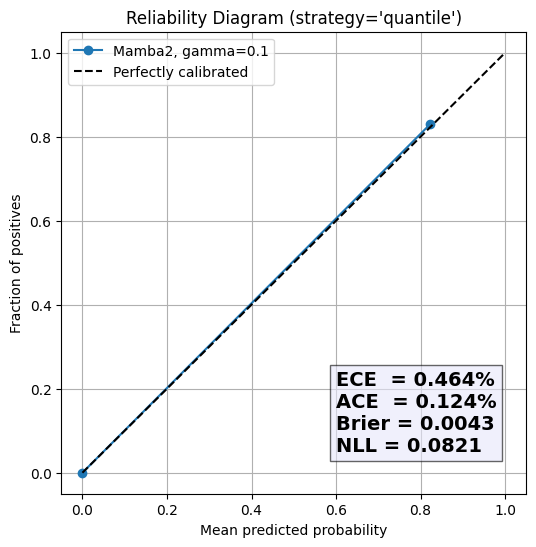

In [75]:
prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [76]:
ece, ece_rows = ece_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00464
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 4  |     2 | [  0.400,   0.500] |      0.500  |      0.500 |       0.000  |     0.00000
 5  |     1 | [  0.500,   0.600] |      0.511  |      1.000 |       0.489  |     0.00033
 6  |    20 | [  0.600,   0.700] |      0.663  |      0.900 |       0.237  |     0.00321
 7  |     4 | [  0.700,   0.800] |      0.778  |      0.750 |       0.028  |     0.00008
 8  |    35 | [  0.800,   0.900] |      0.900  |      0.943 |       0.043  |     0.00102
 9  |  1411 | [  0.900,   1.000] |      1.000  |      1.000 |       0.000  |     0.00000


In [77]:
ace, ace_rows = ace_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00124

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.00000, 0.00000] |    0.000   |   0.000  |    0.000
 1  |   148 | [0.00000, 1.00000] |    0.593   |   0.581  |    0.012
 2  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 3  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 4  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 5  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 6  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 7  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 8  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 9  |   141 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

# CNN + AsymLoss (gamma = 0.1)

In [78]:
from baseline import Conv_Net
model = Conv_Net(in_channel, seq_length, n_hidden, n_output=2)
model = model.to(device)
print(model)

Conv_Net(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=17920, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (features): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=17920, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [79]:
model.load_state_dict(torch.load("models/har_cnn_asymloss_0.1.pth", weights_only=True))

<All keys matched successfully>

In [80]:
model.eval()
logits_train = model(X_train_tensor.to(device)).cpu()
preds_train = torch.max(logits_train, 1)[1]

print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9997    0.9975    0.9986      6366
           1     0.9840    0.9980    0.9909       986

    accuracy                         0.9976      7352
   macro avg     0.9918    0.9977    0.9948      7352
weighted avg     0.9976    0.9976    0.9976      7352

[[6350   16]
 [   2  984]]


In [81]:
model.eval()
logits_val = model(X_val_tensor.to(device)).cpu().detach()
preds_val = torch.max(logits_val, 1)[1]

print(classification_report(y_val, preds_val.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_val, preds_val.cpu().detach().numpy()))

              precision    recall  f1-score   support

           0     0.9882    0.9913    0.9897      1264
           1     0.9466    0.9286    0.9375       210

    accuracy                         0.9824      1474
   macro avg     0.9674    0.9599    0.9636      1474
weighted avg     0.9822    0.9824    0.9823      1474

[[1253   11]
 [  15  195]]


In [82]:
model.eval()
logits_test = model(X_test_tensor.to(device)).cpu().detach()
preds_test = torch.max(logits_test, 1)[1]

print(classification_report(y_test, preds_test.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_test, preds_test.cpu().detach().numpy()))

              precision    recall  f1-score   support

           0     0.9890    0.9952    0.9921      1263
           1     0.9703    0.9333    0.9515       210

    accuracy                         0.9864      1473
   macro avg     0.9796    0.9643    0.9718      1473
weighted avg     0.9863    0.9864    0.9863      1473

[[1257    6]
 [  14  196]]


In [83]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of true positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of true positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of true positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")


Train
Total number of true positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 491
In percentage: 0.9959
Test
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 98
In percentage: 0.9333
Val
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 96
In percentage: 0.9143


## Calibration

In [84]:
y_prob_before = torch.softmax(torch.tensor(logits_test), dim=1).numpy()
n_bins = 10
y_prob_before

array([[9.9999774e-01, 2.2188751e-06],
       [9.9998915e-01, 1.0793373e-05],
       [9.9997950e-01, 2.0499809e-05],
       ...,
       [1.0261516e-02, 9.8973852e-01],
       [9.9995291e-01, 4.7091842e-05],
       [3.5125435e-05, 9.9996483e-01]], shape=(1473, 2), dtype=float32)

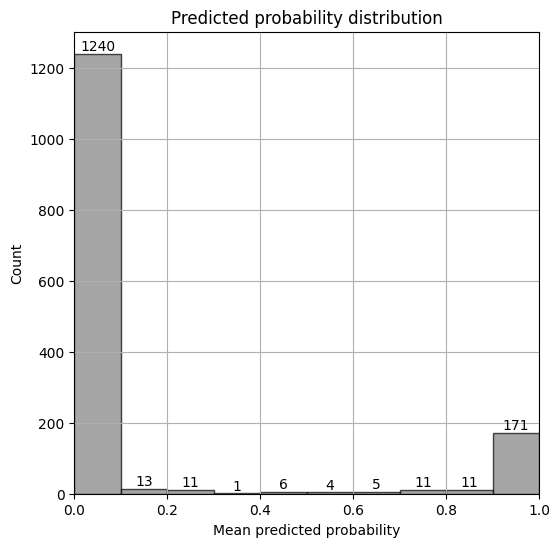

In [85]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(y_prob_before[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(y_prob_before[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

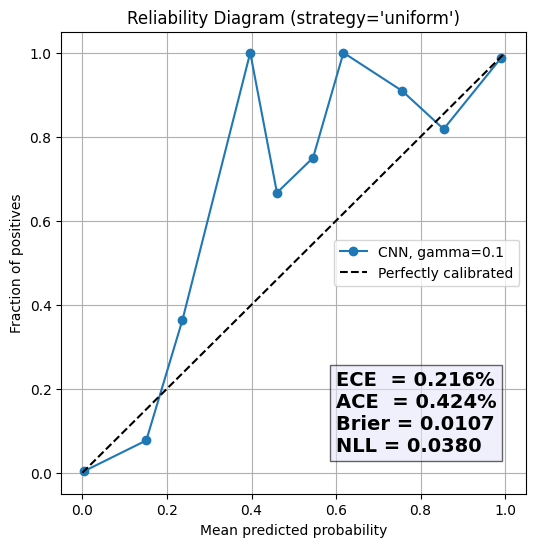

In [86]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_before, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_before[:, 1])
ace = adaptive_calibration_error(y_prob_before, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

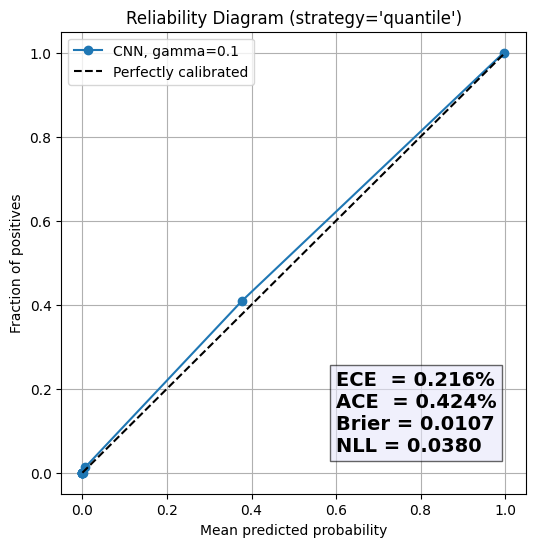

In [87]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

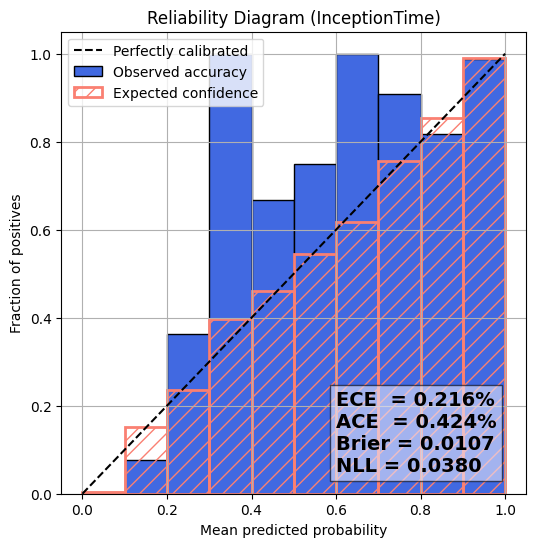

In [88]:
# equal-width binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# Let n_bins be the number of bins you want
n_bins = 10
bins = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# When plotting bars
bin_width = bins[1] - bins[0]

plt.figure(figsize=(6,6))
plt.bar(bin_centers, prob_true, width=bin_width, color='royalblue', edgecolor='black', align='center', label='Observed accuracy')
plt.bar(bin_centers, prob_pred, width=bin_width, fill=False, edgecolor='salmon', linewidth=2, hatch='//', align='center', label='Expected confidence')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (InceptionTime)')
plt.legend()
plt.grid(True)
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

## Temperature Scaling

In [89]:
scaled_model = ModelWithTemperature(model)
scaled_model.set_temperature(logits_val, y_val)

Optimal temperature: 0.971


ModelWithTemperature(
  (model): Conv_Net(
    (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.5, inplace=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=17920, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=2, bias=True)
    (features): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU()
      (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.5, inplace=False)
    )
    (classifier): Sequential(
      (0): Linear(in_features=17920, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64,

In [90]:
scaled_logits_test = scaled_model.temperature_scale(logits_test)
y_prob_after = torch.softmax(torch.tensor(scaled_logits_test), dim=1).numpy()

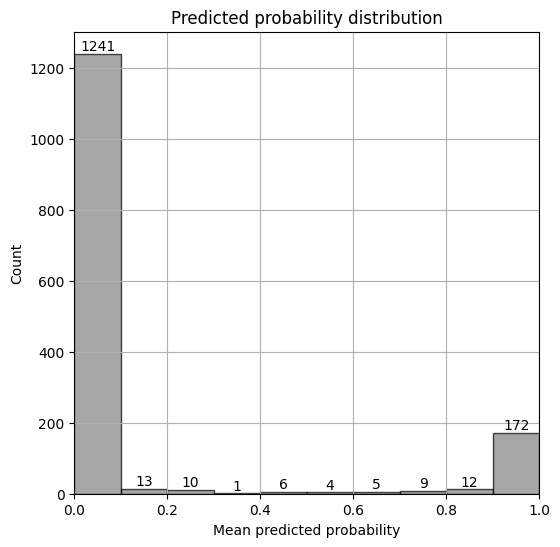

In [91]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(y_prob_after[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(y_prob_after[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

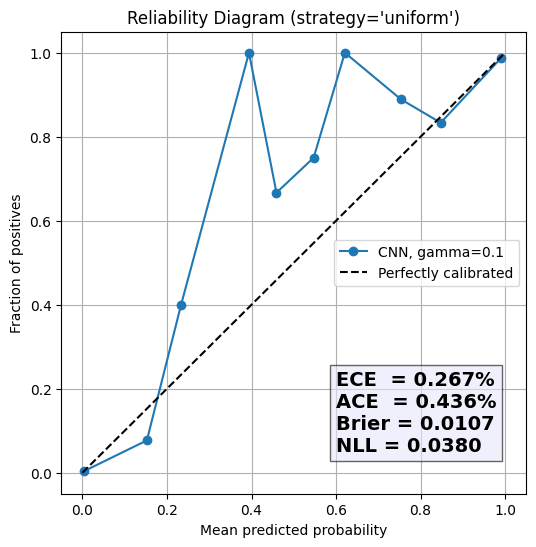

In [92]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_after, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_after[:, 1])
ace = adaptive_calibration_error(y_prob_after, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

## Platt Scaling

In [93]:
s_val = logits_val[:, 1] - logits_val[:, 0]
s_test = logits_test[:, 1] - logits_test[:, 0]
lr = LogisticRegression(solver='lbfgs')
lr.fit(s_val.reshape(-1, 1), y_val)
calibrated_probs = lr.predict_proba(s_test.reshape(-1, 1))
calibrated_probs.shape

(1473, 2)

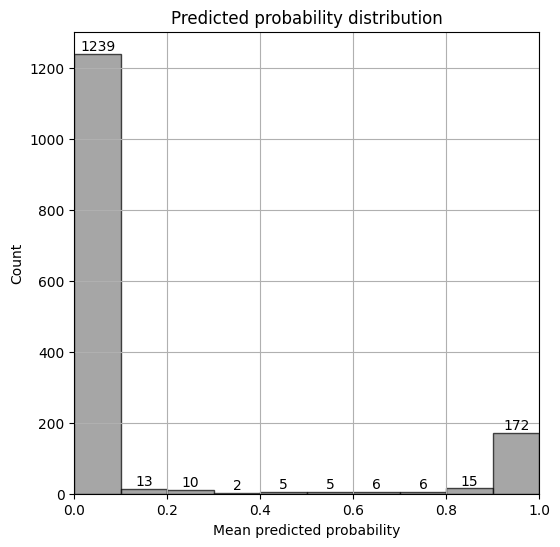

In [94]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(calibrated_probs[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(calibrated_probs[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

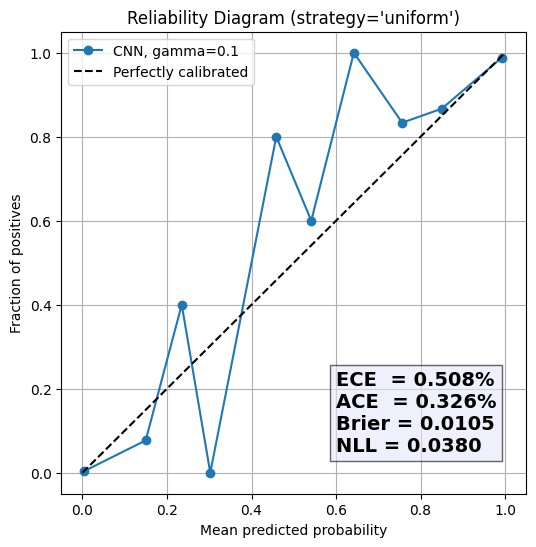

In [95]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, calibrated_probs[:, 1])
ace = adaptive_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

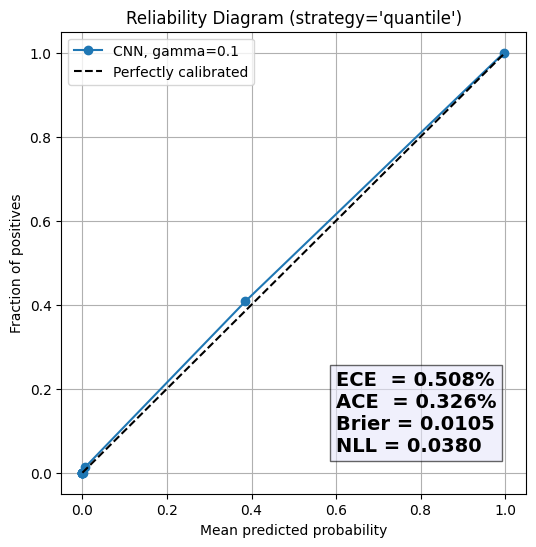

In [96]:
prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [97]:
ece, ece_rows = ece_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00508
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    10 | [  0.500,   0.600] |      0.541  |      0.400 |       0.141  |     0.00096
 6  |     8 | [  0.600,   0.700] |      0.656  |      1.000 |       0.344  |     0.00187
 7  |    16 | [  0.700,   0.800] |      0.762  |      0.688 |       0.074  |     0.00081
 8  |    28 | [  0.800,   0.900] |      0.850  |      0.893 |       0.043  |     0.00081
 9  |  1411 | [  0.900,   1.000] |      0.996  |      0.996 |       0.001  |     0.00063


In [98]:
ace, ace_rows = ace_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00326

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.00002, 0.01953] |    0.003   |   0.000  |    0.003
 1  |   148 | [0.01981, 0.98139] |    0.617   |   0.595  |    0.022
 2  |   148 | [0.98143, 0.99807] |    0.993   |   0.986  |    0.007
 3  |   148 | [0.99810, 0.99981] |    0.999   |   1.000  |    0.001
 4  |   148 | [0.99982, 0.99997] |    1.000   |   1.000  |    0.000
 5  |   148 | [0.99997, 0.99999] |    1.000   |   1.000  |    0.000
 6  |   148 | [0.99999, 0.99999] |    1.000   |   1.000  |    0.000
 7  |   148 | [0.99999, 1.00000] |    1.000   |   1.000  |    0.000
 8  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 9  |   141 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Isotonic Regression

In [99]:
p_val = torch.softmax(logits_val, dim=1).detach().cpu().numpy()[:, 1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_val, y_val)

p_test = torch.softmax(logits_test, dim=1).detach().cpu().numpy()[:, 1]
p_test_cal = iso.transform(p_test)
p_test_calibrated = np.column_stack([1 - p_test_cal, p_test_cal])  


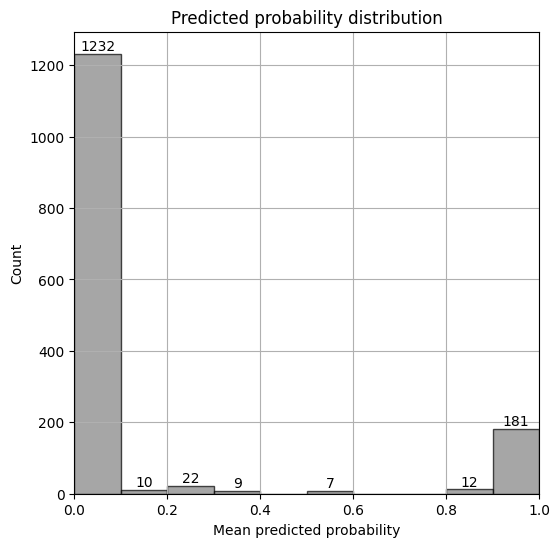

In [100]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(p_test_calibrated[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(p_test_calibrated[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

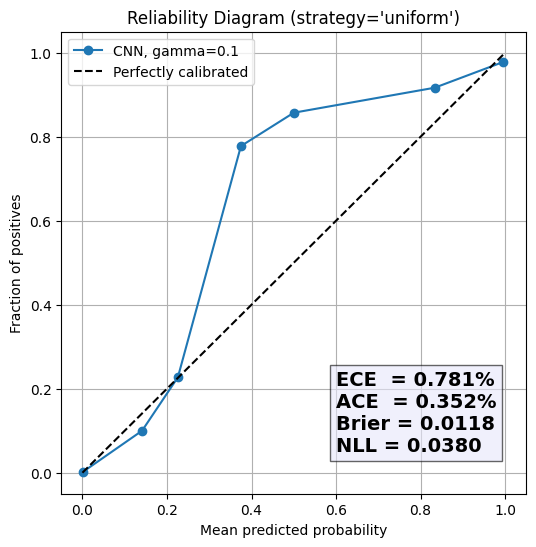

In [101]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, p_test_calibrated[:, 1])
ace = adaptive_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='uniform')
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

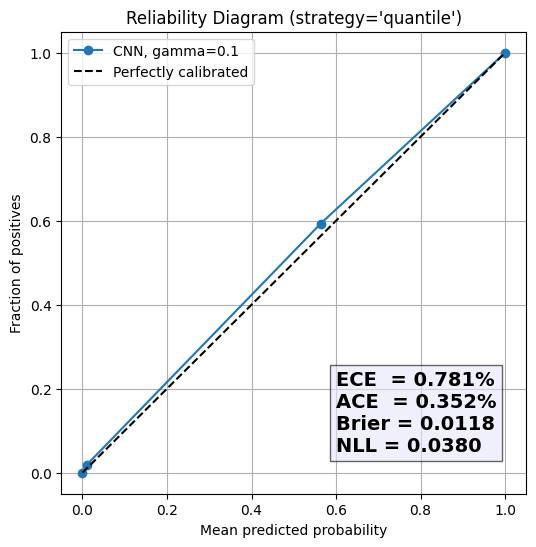

In [102]:
prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [103]:
ece, ece_rows = ece_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00781
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 4  |     7 | [  0.400,   0.500] |      0.500  |      0.143 |       0.357  |     0.00170
 6  |     9 | [  0.600,   0.700] |      0.625  |      0.222 |       0.403  |     0.00246
 7  |    22 | [  0.700,   0.800] |      0.774  |      0.773 |       0.001  |     0.00002
 8  |    22 | [  0.800,   0.900] |      0.845  |      0.909 |       0.064  |     0.00096
 9  |  1413 | [  0.900,   1.000] |      0.998  |      0.995 |       0.003  |     0.00268


In [104]:
ace, ace_rows = ace_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00352

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.00000, 0.02000] |    0.001   |   0.007  |    0.005
 1  |   148 | [0.02000, 0.99029] |    0.614   |   0.581  |    0.033
 2  |   148 | [0.99029, 1.00000] |    0.995   |   0.993  |    0.002
 3  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 4  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 5  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 6  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 7  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 8  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 9  |   141 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

# InceptionTime + weighted CE Loss

In [86]:
from tsai.all import *
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_test_pu)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_pu)
ce_weight = torch.tensor(weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=ce_weight)
print(ce_weight)
X_all = np.concatenate([X_train, X_val]).astype(np.float32)
y_all = np.concatenate([y_train_pu, y_val])

splits = (list(range(len(y_train_pu))),
          list(range(len(y_train_pu), len(y_all))))

tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)

clf = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus", arch_config=dict(fc_dropout=.3),
                   tfms=tfms, batch_tfms=batch_tfms,train_metrics=True, loss_func=criterion,
                   metrics=accuracy, cbs=ShowGraph(), wd=1e-3)


tensor([0.5359, 7.4564], device='cuda:0')


In [17]:
X_all = X_all.reshape(X_all.shape[0], 1, X_all.shape[1])
X_all.shape


(8826, 1, 561)

In [18]:
clf.load("har_inctime_wCE")

In [19]:
# Train metrics

logits_train, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds_train = logits_train.argmax(dim=-1)
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9955    0.9998    0.9976      6366
           1     0.9990    0.9706    0.9846       986

    accuracy                         0.9959      7352
   macro avg     0.9972    0.9852    0.9911      7352
weighted avg     0.9959    0.9959    0.9959      7352

[[6365    1]
 [  29  957]]


In [20]:
# Val metrics

logits_val, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds_val = logits_val.argmax(dim=-1)
print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9693    0.9992    0.9840      1264
           1     0.9942    0.8095    0.8924       210

    accuracy                         0.9722      1474
   macro avg     0.9817    0.9044    0.9382      1474
weighted avg     0.9728    0.9722    0.9710      1474

[[1263    1]
 [  40  170]]


In [21]:
# Test metrics
logits_test, target = clf.get_X_preds(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]), y_test_pu, with_decoded=False)
preds_test = logits_test.argmax(dim=-1)
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9715    1.0000    0.9856      1263
           1     1.0000    0.8238    0.9034       210

    accuracy                         0.9749      1473
   macro avg     0.9858    0.9119    0.9445      1473
weighted avg     0.9756    0.9749    0.9738      1473

[[1263    0]
 [  37  173]]


In [22]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of true positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of true positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of true positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")


Train
Total number of true positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 464
In percentage: 0.9412
Test
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 86
In percentage: 0.8190
Val
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 88
In percentage: 0.8381


## Calibration

In [27]:
y_prob_before = torch.softmax(torch.tensor(logits_test), dim=1).numpy()
n_bins = 10
y_prob_before

array([[0.9919241 , 0.00807585],
       [0.9971733 , 0.0028267 ],
       [0.98065656, 0.01934346],
       ...,
       [0.45548934, 0.54451066],
       [0.99325895, 0.00674113],
       [0.02660624, 0.97339374]], shape=(1473, 2), dtype=float32)

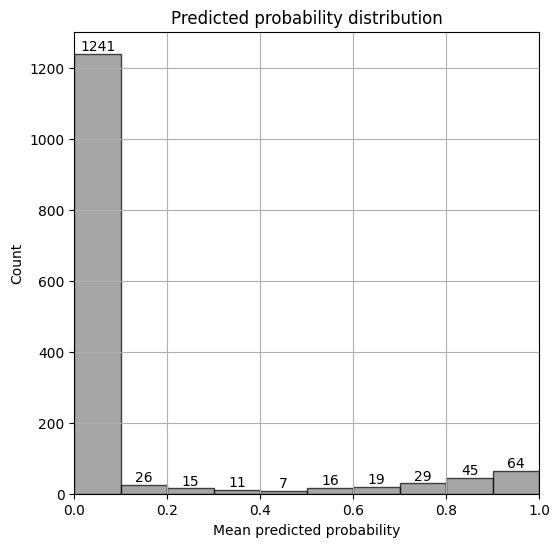

In [28]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(y_prob_before[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(y_prob_before[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

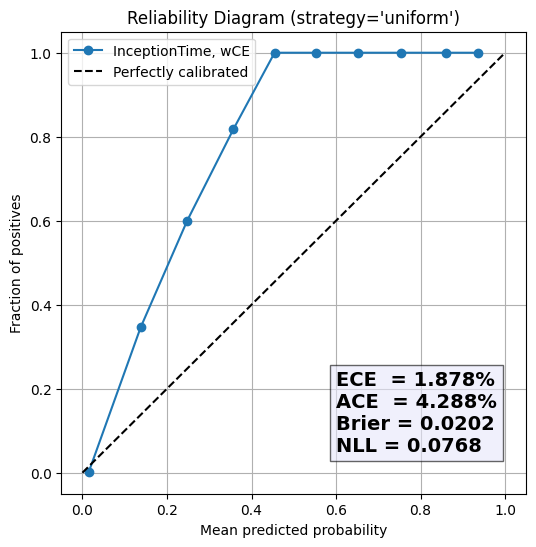

In [29]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_before, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_before[:, 1])
ace = adaptive_calibration_error(y_prob_before, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, wCE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

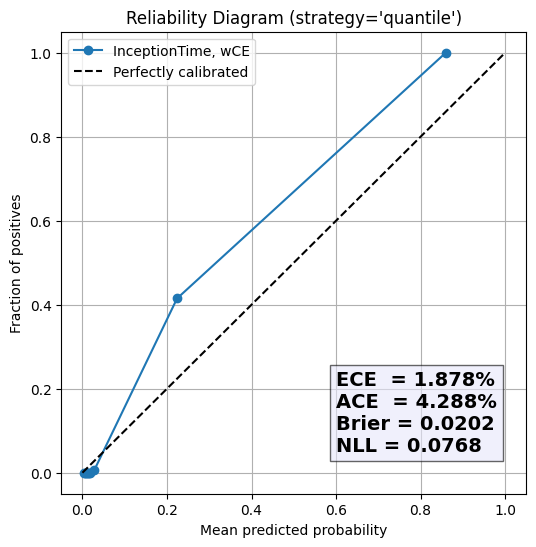

In [30]:
# strategy='quantile' = equal-mass binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, wCE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

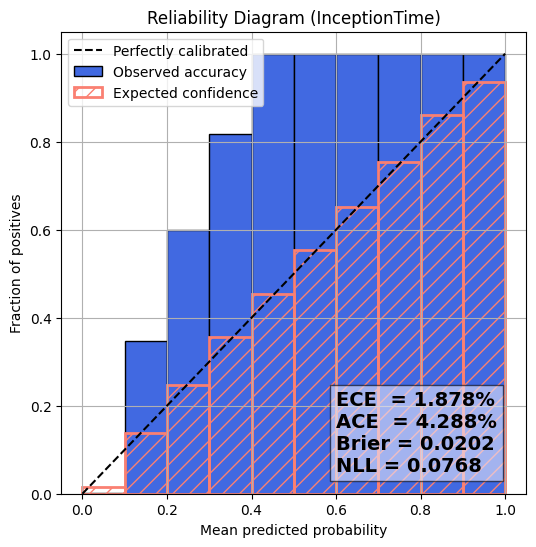

In [31]:
# equal-width binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# Let n_bins be the number of bins you want
n_bins = 10
bins = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# When plotting bars
bin_width = bins[1] - bins[0]

plt.figure(figsize=(6,6))
plt.bar(bin_centers, prob_true, width=bin_width, color='royalblue', edgecolor='black', align='center', label='Observed accuracy')
plt.bar(bin_centers, prob_pred, width=bin_width, fill=False, edgecolor='salmon', linewidth=2, hatch='//', align='center', label='Expected confidence')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (InceptionTime)')
plt.legend()
plt.grid(True)
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

## Temperature Scaling

In [32]:
scaled_model = ModelWithTemperature(clf)
scaled_model.set_temperature(logits_val, y_val)

Optimal temperature: 0.704


ModelWithTemperature()

In [33]:
scaled_logits_test = scaled_model.temperature_scale(logits_test)
y_prob_after = torch.softmax(torch.tensor(scaled_logits_test), dim=1).numpy()

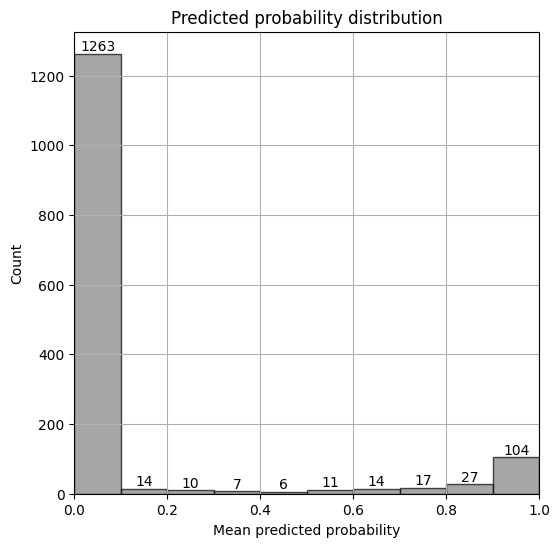

In [34]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(y_prob_after[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(y_prob_after[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

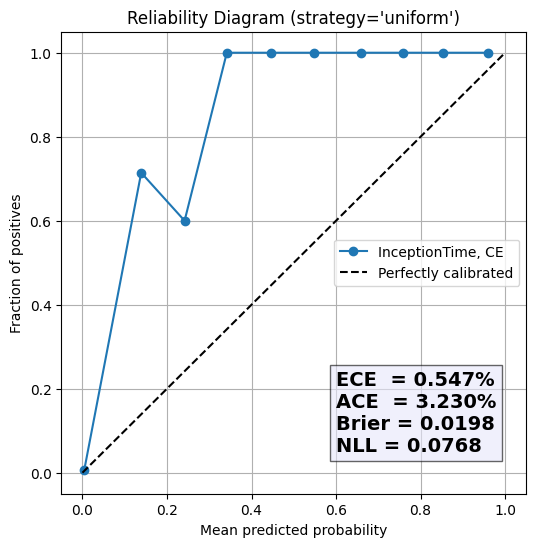

In [35]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_after, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_after[:, 1])
ace = adaptive_calibration_error(y_prob_after, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

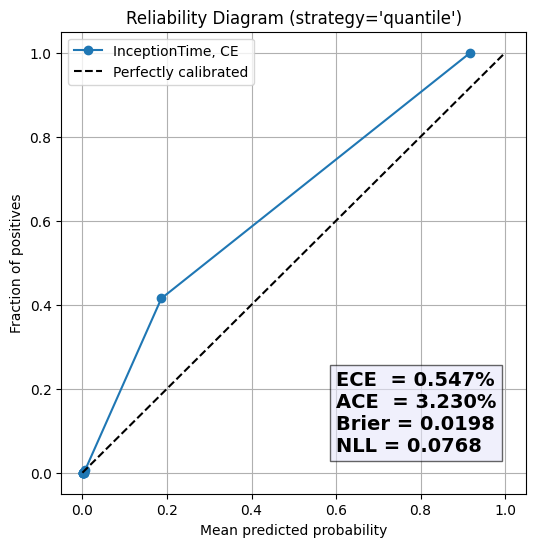

In [36]:
# strategy='quantile' -> equal-mass binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [37]:
ece, ece_rows = ece_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00547
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    17 | [  0.500,   0.600] |      0.550  |      0.647 |       0.097  |     0.00112
 6  |    21 | [  0.600,   0.700] |      0.659  |      0.667 |       0.008  |     0.00011
 7  |    27 | [  0.700,   0.800] |      0.758  |      0.778 |       0.020  |     0.00037
 8  |    41 | [  0.800,   0.900] |      0.856  |      0.756 |       0.100  |     0.00279
 9  |  1367 | [  0.900,   1.000] |      0.993  |      0.994 |       0.001  |     0.00109


In [38]:
ace, ace_rows = ace_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.03230

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.00178, 0.28473] |    0.082   |   0.000  |    0.082
 1  |   148 | [0.30138, 0.98802] |    0.814   |   0.588  |    0.227
 2  |   148 | [0.98808, 0.99592] |    0.993   |   0.993  |    0.000
 3  |   148 | [0.99593, 0.99712] |    0.997   |   1.000  |    0.003
 4  |   148 | [0.99713, 0.99773] |    0.997   |   1.000  |    0.003
 5  |   148 | [0.99774, 0.99824] |    0.998   |   1.000  |    0.002
 6  |   148 | [0.99825, 0.99864] |    0.998   |   1.000  |    0.002
 7  |   148 | [0.99864, 0.99909] |    0.999   |   1.000  |    0.001
 8  |   148 | [0.99909, 0.99954] |    0.999   |   1.000  |    0.001
 9  |   141 | [0.99955, 0.99999] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Platt Scaling

In [39]:
s_val = logits_val[:, 1] - logits_val[:, 0]
s_test = logits_test[:, 1] - logits_test[:, 0]
lr = LogisticRegression(solver='lbfgs')
lr.fit(s_val.reshape(-1, 1), y_val)
calibrated_probs = lr.predict_proba(s_test.reshape(-1, 1))
calibrated_probs.shape

(1473, 2)

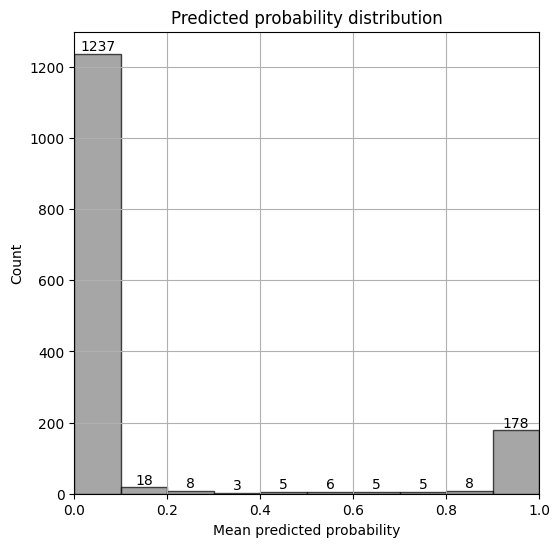

In [40]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(calibrated_probs[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(calibrated_probs[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

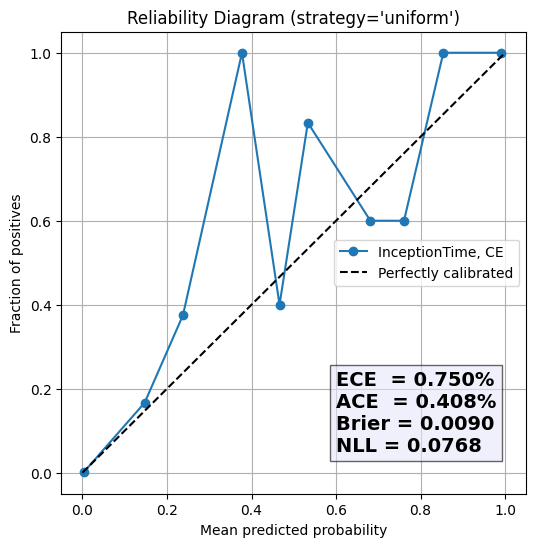

In [41]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, calibrated_probs[:, 1])
ace = adaptive_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

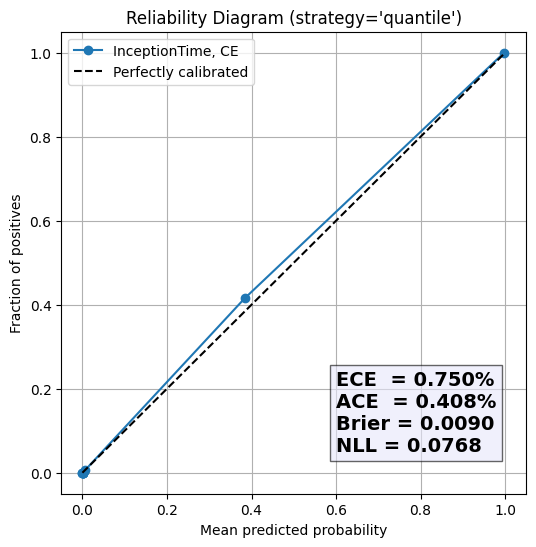

In [42]:
prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [43]:
ece, ece_rows = ece_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00750
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    11 | [  0.500,   0.600] |      0.533  |      0.727 |       0.194  |     0.00145
 6  |     8 | [  0.600,   0.700] |      0.659  |      0.375 |       0.284  |     0.00154
 7  |    13 | [  0.700,   0.800] |      0.762  |      0.615 |       0.146  |     0.00129
 8  |    26 | [  0.800,   0.900] |      0.853  |      0.885 |       0.032  |     0.00056
 9  |  1415 | [  0.900,   1.000] |      0.996  |      0.999 |       0.003  |     0.00267


In [44]:
ace, ace_rows = ace_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00408

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.00000, 0.01531] |    0.002   |   0.000  |    0.002
 1  |   148 | [0.01730, 0.98355] |    0.619   |   0.588  |    0.031
 2  |   148 | [0.98369, 0.99689] |    0.993   |   0.993  |    0.000
 3  |   148 | [0.99690, 0.99819] |    0.998   |   1.000  |    0.002
 4  |   148 | [0.99819, 0.99875] |    0.998   |   1.000  |    0.002
 5  |   148 | [0.99875, 0.99916] |    0.999   |   1.000  |    0.001
 6  |   148 | [0.99916, 0.99943] |    0.999   |   1.000  |    0.001
 7  |   148 | [0.99943, 0.99970] |    1.000   |   1.000  |    0.000
 8  |   148 | [0.99970, 0.99990] |    1.000   |   1.000  |    0.000
 9  |   141 | [0.99990, 1.00000] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Isotonic Regression

In [45]:
p_val = torch.softmax(logits_val, dim=1).detach().cpu().numpy()[:, 1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_val, y_val)

p_test = torch.softmax(logits_test, dim=1).detach().cpu().numpy()[:, 1]
p_test_cal = iso.transform(p_test)
p_test_calibrated = np.column_stack([1 - p_test_cal, p_test_cal])  


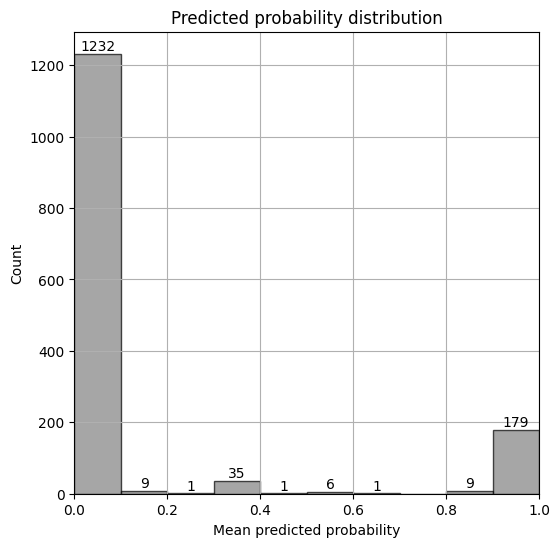

In [46]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(p_test_calibrated[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(p_test_calibrated[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

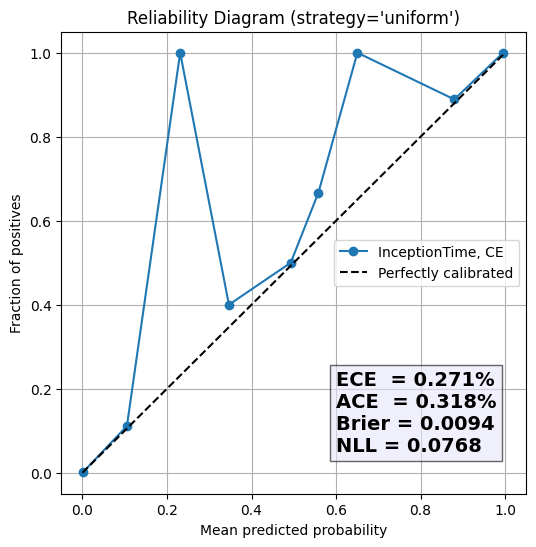

In [47]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, p_test_calibrated[:, 1])
ace = adaptive_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='uniform')
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

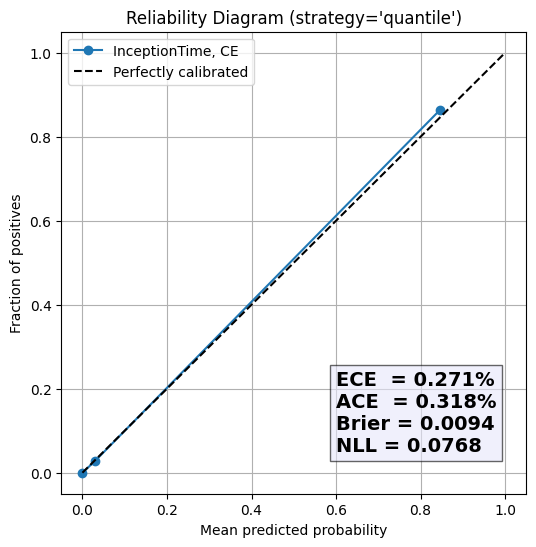

In [48]:
prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

# Mamba2 + weighted CE Loss

In [87]:
from baseline import Mamba2Classifier, train, PULoss

model_mamba = Mamba2Classifier(in_channel, hidden_dim=256, num_classes=2, num_layers=2, dropout=0.1)
model_mamba = model_mamba.to(device)
print(model_mamba)

256 2 64
256 2 64
Mamba2Classifier(
  (input_proj): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (input_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, out_features=256, bias=False)
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, ou

In [88]:
model_mamba.load_state_dict(torch.load("models/har_mamba2_convproj_wCE.pth", weights_only=True))

<All keys matched successfully>

In [89]:
X_test_tensor_perm = X_test_tensor.permute(0, 2, 1)
test_dataset = TensorDataset(X_test_tensor_perm, torch.tensor(y_test_pu, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=64)  

X_val_tensor_perm = X_val_tensor.permute(0, 2, 1)
val_dataset = TensorDataset(X_val_tensor_perm, torch.tensor(y_val_pu, dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=64)  

X_train_tensor_perm = X_train_tensor.permute(0, 2, 1)
train_dataset = TensorDataset(X_train_tensor_perm, torch.tensor(y_train_pu, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64)  
print(X_test_tensor_perm.shape)
print(X_train_tensor_perm.shape)

torch.Size([1473, 561, 1])
torch.Size([7352, 561, 1])


In [90]:
#Mamba2
preds_train = []
logits_train = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_train.append(preds.cpu())
        logits_train.append(outputs.cpu().detach())

# Concatenate all predictions
preds_train = torch.cat(preds_train).numpy()
logits_train = torch.cat(logits_train)

print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9994    0.9903    0.9948      6366
           1     0.9406    0.9959    0.9675       986

    accuracy                         0.9910      7352
   macro avg     0.9700    0.9931    0.9811      7352
weighted avg     0.9915    0.9910    0.9911      7352

[[6304   62]
 [   4  982]]


In [56]:
preds_val = []
logits_val = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in val_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_val.append(preds.cpu())
        logits_val.append(outputs.cpu().detach())

# Concatenate all predictions
preds_val = torch.cat(preds_val).numpy()
logits_val = torch.cat(logits_val)

print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9920    0.9786    0.9853      1264
           1     0.8811    0.9524    0.9153       210

    accuracy                         0.9749      1474
   macro avg     0.9365    0.9655    0.9503      1474
weighted avg     0.9762    0.9749    0.9753      1474

[[1237   27]
 [  10  200]]


In [57]:
preds_test = []
logits_test = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        preds_test.append(preds.cpu())
        logits_test.append(outputs.cpu().detach())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()
logits_test = torch.cat(logits_test)

print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9826    0.9842    0.9834      1263
           1     0.9038    0.8952    0.8995       210

    accuracy                         0.9715      1473
   macro avg     0.9432    0.9397    0.9415      1473
weighted avg     0.9714    0.9715    0.9714      1473

[[1243   20]
 [  22  188]]


In [58]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")


Train
Total number of positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 489
In percentage: 0.9919
Val
Total number of positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 100
In percentage: 0.9524
Test
Total number of positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 97
In percentage: 0.9238


## Calibration

In [59]:
y_prob_before = torch.softmax(torch.tensor(logits_test), dim=1).numpy()
n_bins = 10
y_prob_before

array([[9.9999189e-01, 8.0805939e-06],
       [9.9992526e-01, 7.4739954e-05],
       [9.9997222e-01, 2.7787984e-05],
       ...,
       [3.2180522e-02, 9.6781945e-01],
       [9.9973899e-01, 2.6102873e-04],
       [1.2963674e-02, 9.8703641e-01]], shape=(1473, 2), dtype=float32)

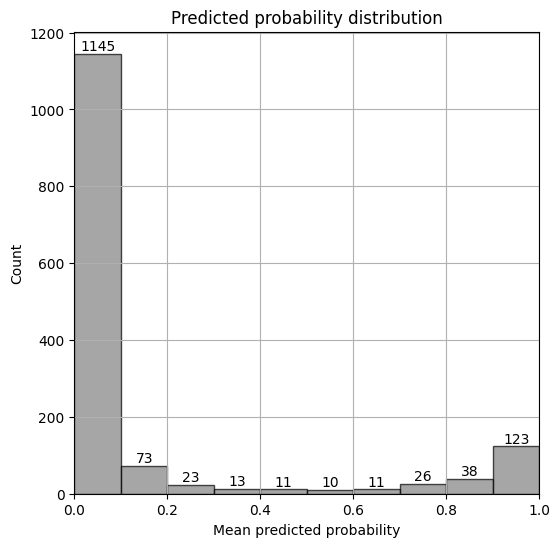

In [60]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(y_prob_before[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(y_prob_before[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

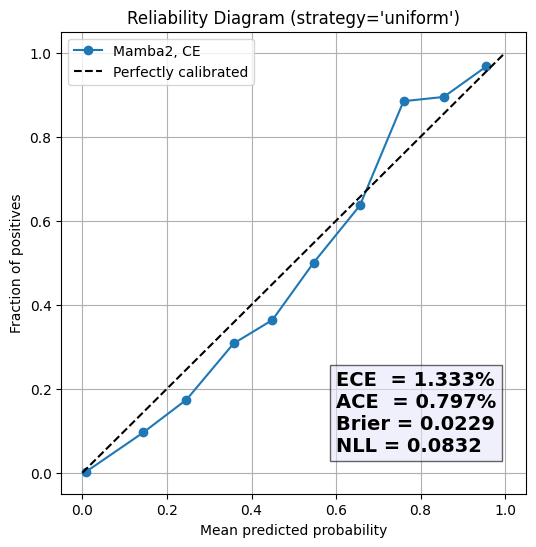

In [61]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_before, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_before[:, 1])
ace = adaptive_calibration_error(y_prob_before, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

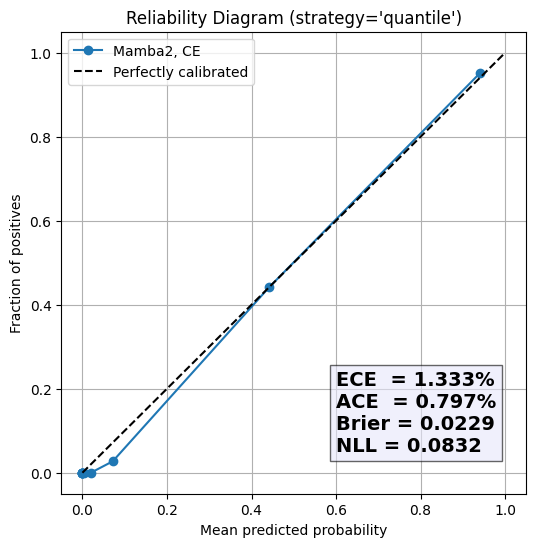

In [62]:
# strategy='quantile' = equal-mass binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, CE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

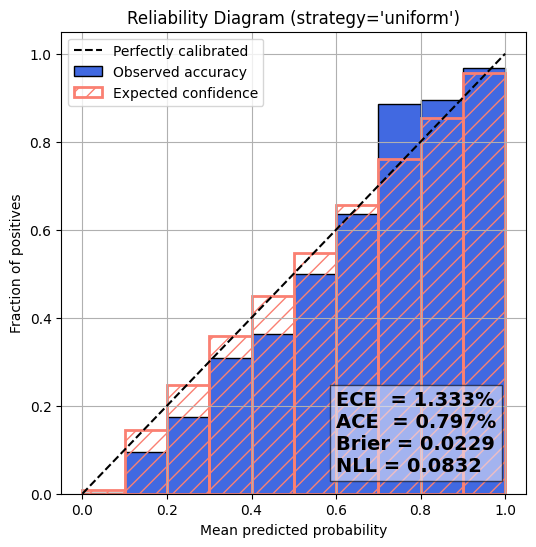

In [63]:
# equal-width binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# Let n_bins be the number of bins you want
n_bins = 10
bins = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# When plotting bars
bin_width = bins[1] - bins[0]

plt.figure(figsize=(6,6))
plt.bar(bin_centers, prob_true, width=bin_width, color='royalblue', edgecolor='black', align='center', label='Observed accuracy')
plt.bar(bin_centers, prob_pred, width=bin_width, fill=False, edgecolor='salmon', linewidth=2, hatch='//', align='center', label='Expected confidence')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid(True)
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

## Temperature Scaling

In [64]:
scaled_model = ModelWithTemperature(model_mamba)
scaled_model.set_temperature(logits_val, y_val)

Optimal temperature: 0.692


ModelWithTemperature(
  (model): Mamba2Classifier(
    (input_proj): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (input_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (blocks): Sequential(
      (0): Mamba2Block(
        (mamba): Mamba2(
          (in_proj): Linear(in_features=256, out_features=1288, bias=False)
          (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
          (act): SiLU()
          (norm): RMSNorm()
          (out_proj): Linear(in_features=512, out_features=256, bias=False)
        )
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): Mamba2Block(
        (mamba): Mamba2(
          (in_proj): Linear(in_features=256, out_features=1288, bias=False)
          (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
          (act): SiLU()
          (norm): R

In [65]:
scaled_logits_test = scaled_model.temperature_scale(logits_test)
y_prob_after = torch.softmax(torch.tensor(scaled_logits_test), dim=1).numpy()

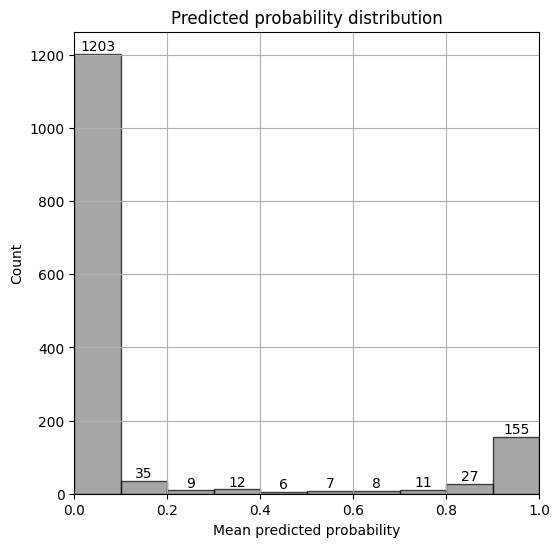

In [66]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(y_prob_after[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(y_prob_after[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

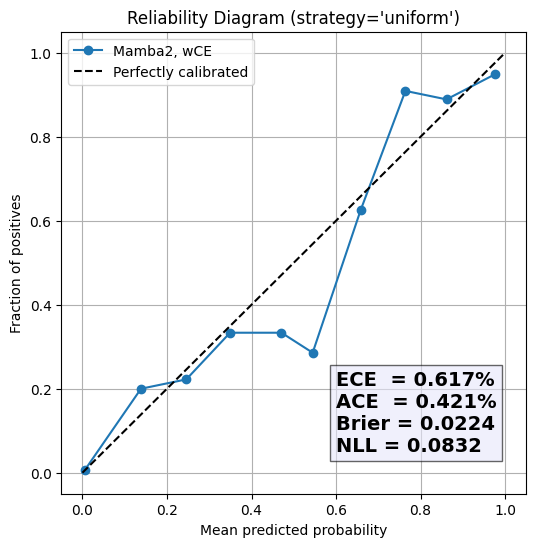

In [67]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_after, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_after[:, 1])
ace = adaptive_calibration_error(y_prob_after, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, wCE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

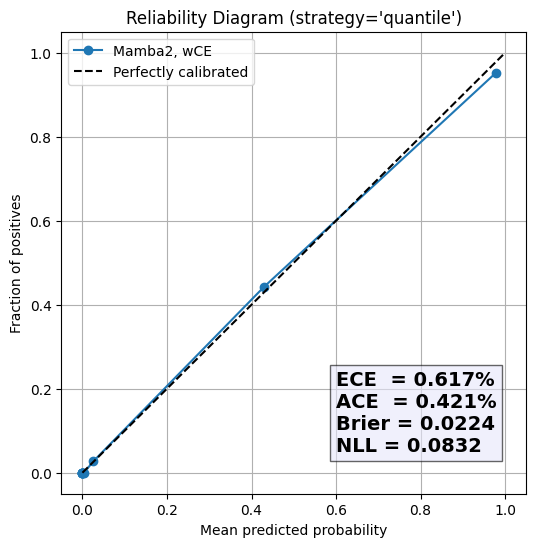

In [68]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, wCE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [69]:
ece, ece_rows = ece_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00617
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    13 | [  0.500,   0.600] |      0.538  |      0.462 |       0.076  |     0.00067
 6  |    20 | [  0.600,   0.700] |      0.654  |      0.650 |       0.004  |     0.00005
 7  |    20 | [  0.700,   0.800] |      0.760  |      0.850 |       0.090  |     0.00123
 8  |    62 | [  0.800,   0.900] |      0.861  |      0.839 |       0.023  |     0.00095
 9  |  1358 | [  0.900,   1.000] |      0.993  |      0.989 |       0.004  |     0.00327


In [70]:
ace, ace_rows = ace_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00421

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.00006, 0.08663] |    0.021   |   0.047  |    0.026
 1  |   148 | [0.08785, 0.93581] |    0.573   |   0.561  |    0.012
 2  |   148 | [0.93607, 0.99244] |    0.975   |   0.973  |    0.002
 3  |   148 | [0.99249, 0.99858] |    0.996   |   1.000  |    0.004
 4  |   148 | [0.99860, 0.99999] |    1.000   |   1.000  |    0.000
 5  |   148 | [0.99999, 1.00000] |    1.000   |   1.000  |    0.000
 6  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 7  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 8  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 9  |   141 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Platt Scaling

In [71]:
s_val = logits_val[:, 1] - logits_val[:, 0]
s_test = logits_test[:, 1] - logits_test[:, 0]
lr = LogisticRegression(solver='lbfgs')
lr.fit(s_val.reshape(-1, 1), y_val)
calibrated_probs = lr.predict_proba(s_test.reshape(-1, 1))
calibrated_probs.shape

(1473, 2)

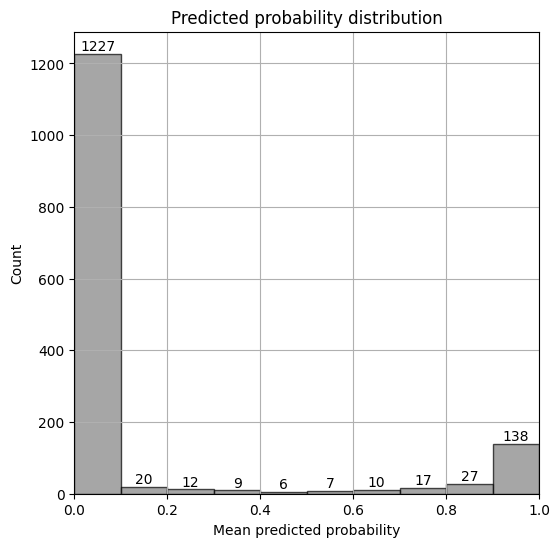

In [72]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(calibrated_probs[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(calibrated_probs[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

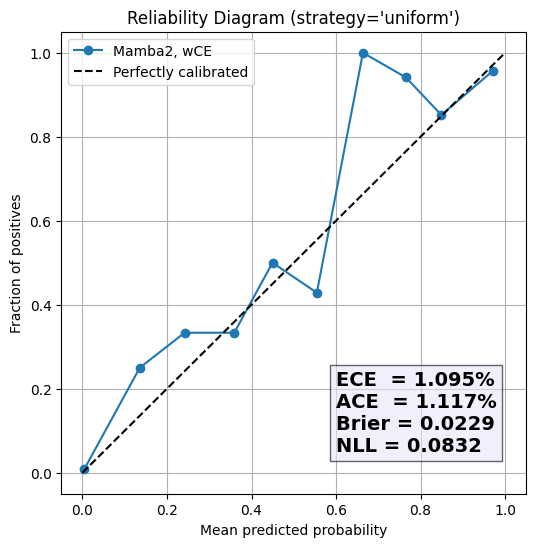

In [73]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, calibrated_probs[:, 1])
ace = adaptive_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, wCE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

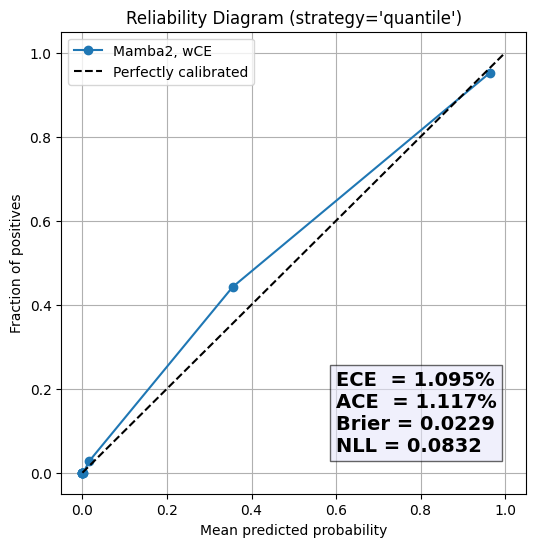

In [74]:
prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, wCE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [75]:
ece, ece_rows = ece_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.01095
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    13 | [  0.500,   0.600] |      0.553  |      0.462 |       0.091  |     0.00080
 6  |    19 | [  0.600,   0.700] |      0.653  |      0.842 |       0.189  |     0.00244
 7  |    29 | [  0.700,   0.800] |      0.762  |      0.828 |       0.065  |     0.00128
 8  |    47 | [  0.800,   0.900] |      0.855  |      0.809 |       0.047  |     0.00150
 9  |  1365 | [  0.900,   1.000] |      0.993  |      0.988 |       0.005  |     0.00492


In [76]:
ace, ace_rows = ace_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.01117

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.00010, 0.13942] |    0.036   |   0.047  |    0.012
 1  |   148 | [0.14127, 0.96059] |    0.647   |   0.561  |    0.086
 2  |   148 | [0.96075, 0.99542] |    0.985   |   0.973  |    0.012
 3  |   148 | [0.99545, 0.99913] |    0.998   |   1.000  |    0.002
 4  |   148 | [0.99915, 0.99999] |    1.000   |   1.000  |    0.000
 5  |   148 | [0.99999, 1.00000] |    1.000   |   1.000  |    0.000
 6  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 7  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 8  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 9  |   141 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Isotonic Regression

In [77]:
p_val = torch.softmax(logits_val, dim=1).detach().cpu().numpy()[:, 1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_val, y_val)

p_test = torch.softmax(logits_test, dim=1).detach().cpu().numpy()[:, 1]
p_test_cal = iso.transform(p_test)
p_test_calibrated = np.column_stack([1 - p_test_cal, p_test_cal])  

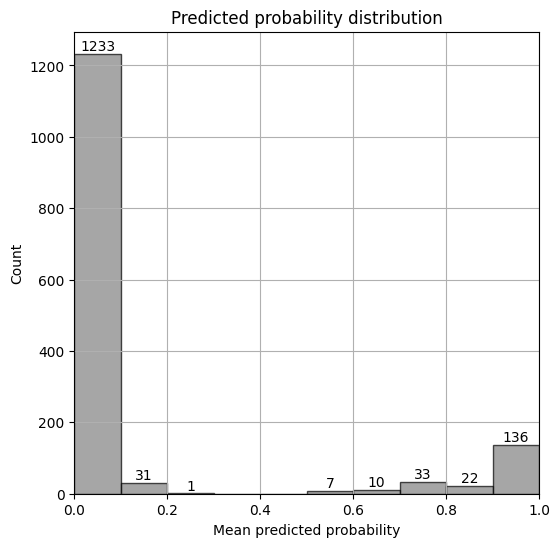

In [78]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(p_test_calibrated[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(p_test_calibrated[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

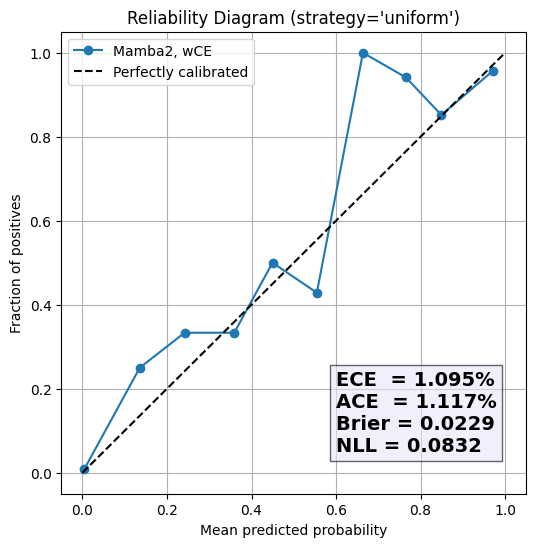

In [79]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, calibrated_probs[:, 1])
ace = adaptive_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, wCE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

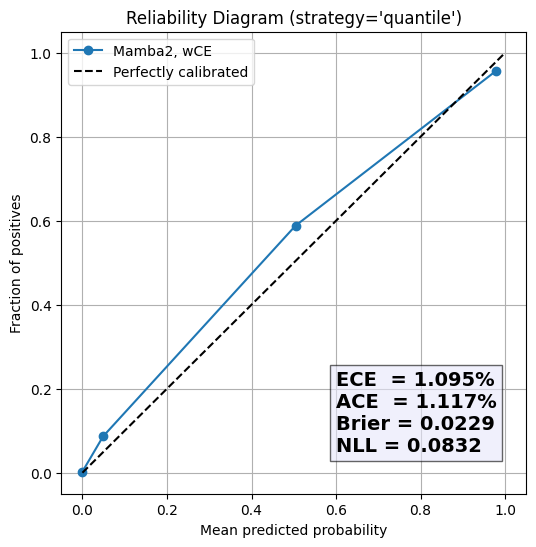

In [80]:
prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, wCE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [81]:
ece, ece_rows = ece_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.01485
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |     7 | [  0.500,   0.600] |      0.583  |      0.286 |       0.298  |     0.00141
 6  |    10 | [  0.600,   0.700] |      0.667  |      0.600 |       0.067  |     0.00045
 7  |    34 | [  0.700,   0.800] |      0.728  |      0.882 |       0.155  |     0.00357
 8  |    53 | [  0.800,   0.900] |      0.864  |      0.811 |       0.053  |     0.00189
 9  |  1369 | [  0.900,   1.000] |      0.994  |      0.986 |       0.008  |     0.00752


In [82]:
ace, ace_rows = ace_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.01291

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.00000, 0.11538] |    0.030   |   0.047  |    0.017
 1  |   148 | [0.11538, 0.94737] |    0.652   |   0.568  |    0.084
 2  |   148 | [0.94737, 1.00000] |    0.988   |   0.986  |    0.001
 3  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 4  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 5  |   148 | [1.00000, 1.00000] |    1.000   |   0.993  |    0.007
 6  |   148 | [1.00000, 1.00000] |    1.000   |   0.993  |    0.007
 7  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 8  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 9  |   141 | [1.00000, 1.00000] |    1.000   |   0.993  |    0.007

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

# CNN + weighted CE Loss

In [12]:
print(X_train_tensor.shape)
train_dataset = TensorDataset(X_train_tensor, y_train_pu_tensor)
val_dataset = TensorDataset(X_val_tensor, torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.long))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([7352, 1, 561])


In [13]:
in_channel = X_train_tensor.shape[1]
seq_length = X_train_tensor.shape[2]
print(f'in_channel: {in_channel}, sequence_length: {seq_length}')
n_hidden = 64


in_channel: 1, sequence_length: 561


In [15]:
from baseline import Conv_Net
model = Conv_Net(in_channel, seq_length, n_hidden, n_output=2, dropout=0.2)
model = model.to(device)
print(model)

Conv_Net(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=17920, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (features): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=17920, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [16]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_test_pu)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_test_pu)
ce_weight = torch.tensor(weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=ce_weight)

print(ce_weight)

tensor([0.5384, 7.0143], device='cuda:0')


In [17]:
model.load_state_dict(torch.load("models/har_cnn_wCE.pth", weights_only=True))

<All keys matched successfully>

In [18]:
model.eval()
logits_train = model(X_train_tensor.to(device)).cpu()
preds_train = torch.max(logits_train, 1)[1]

print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9998    0.9961    0.9980      6366
           1     0.9752    0.9990    0.9870       986

    accuracy                         0.9965      7352
   macro avg     0.9875    0.9975    0.9925      7352
weighted avg     0.9965    0.9965    0.9965      7352

[[6341   25]
 [   1  985]]


In [19]:
model.eval()
logits_val = model(X_val_tensor.to(device)).cpu().detach()
preds_val = torch.max(logits_val, 1)[1]

print(classification_report(y_val, preds_val.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_val, preds_val.cpu().detach().numpy()))

              precision    recall  f1-score   support

           0     0.9851    0.9929    0.9890      1264
           1     0.9550    0.9095    0.9317       210

    accuracy                         0.9810      1474
   macro avg     0.9700    0.9512    0.9603      1474
weighted avg     0.9808    0.9810    0.9808      1474

[[1255    9]
 [  19  191]]


In [20]:
model.eval()
logits_test = model(X_test_tensor.to(device)).cpu().detach()
preds_test = torch.max(logits_test, 1)[1]

print(classification_report(y_test, preds_test.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_test, preds_test.cpu().detach().numpy()))

              precision    recall  f1-score   support

           0     0.9867    0.9960    0.9913      1263
           1     0.9747    0.9190    0.9461       210

    accuracy                         0.9851      1473
   macro avg     0.9807    0.9575    0.9687      1473
weighted avg     0.9850    0.9851    0.9849      1473

[[1258    5]
 [  17  193]]


In [21]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")


Train
Total number of positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 492
In percentage: 0.9980
Val
Total number of positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 95
In percentage: 0.9048
Test
Total number of positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 95
In percentage: 0.9048


## Calibration

In [24]:
y_prob_before = torch.softmax(torch.tensor(logits_test), dim=1).numpy()
n_bins = 10
y_prob_before

/tmp/ipykernel_1062696/121546152.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_prob_before = torch.softmax(torch.tensor(logits_test), dim=1).numpy()


array([[9.9995553e-01, 4.4519031e-05],
       [9.9983060e-01, 1.6942449e-04],
       [9.9957103e-01, 4.2898368e-04],
       ...,
       [1.5391511e-01, 8.4608495e-01],
       [9.9932790e-01, 6.7213213e-04],
       [5.2980036e-02, 9.4701993e-01]], shape=(1473, 2), dtype=float32)

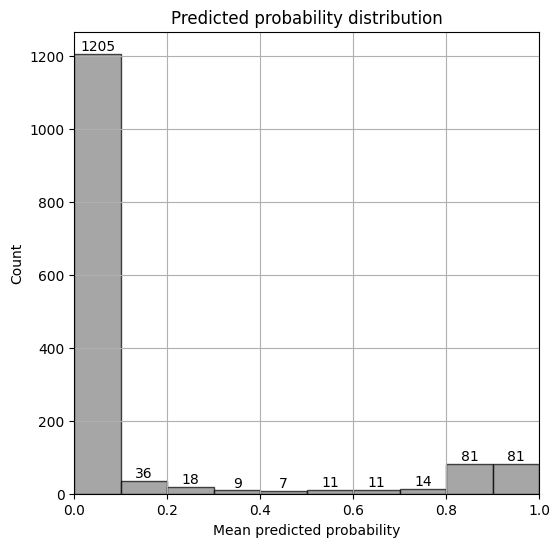

In [25]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(y_prob_before[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(y_prob_before[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

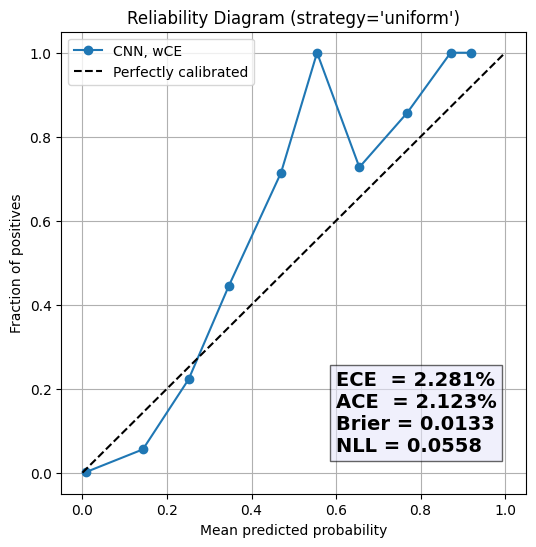

In [26]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_before, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_before[:, 1])
ace = adaptive_calibration_error(y_prob_before, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, wCE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

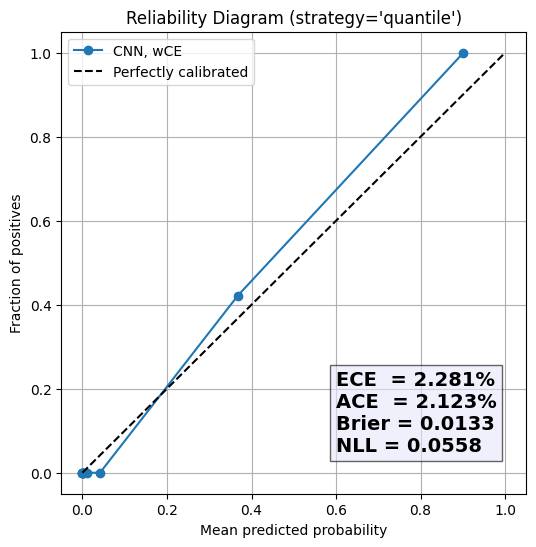

In [27]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, wCE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

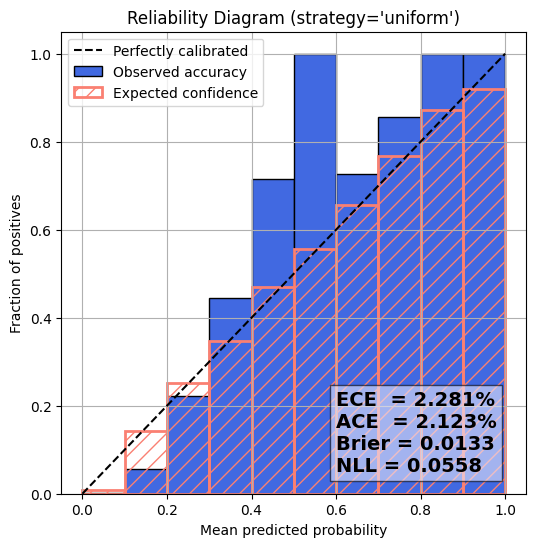

In [28]:
# equal-width binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# Let n_bins be the number of bins you want
n_bins = 10
bins = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# When plotting bars
bin_width = bins[1] - bins[0]

plt.figure(figsize=(6,6))
plt.bar(bin_centers, prob_true, width=bin_width, color='royalblue', edgecolor='black', align='center', label='Observed accuracy')
plt.bar(bin_centers, prob_pred, width=bin_width, fill=False, edgecolor='salmon', linewidth=2, hatch='//', align='center', label='Expected confidence')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid(True)
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

## Temperature Scaling

In [44]:
scaled_model = ModelWithTemperature(model)
scaled_model.set_temperature(logits_val, y_val)

Optimal temperature: 0.545


ModelWithTemperature(
  (model): Conv_Net(
    (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.2, inplace=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=17920, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=2, bias=True)
    (features): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU()
      (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.2, inplace=False)
    )
    (classifier): Sequential(
      (0): Linear(in_features=17920, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64,

In [46]:
scaled_logits_test = scaled_model.temperature_scale(logits_test)
y_prob_after = torch.softmax(torch.tensor(scaled_logits_test), dim=1).numpy()

/tmp/ipykernel_1062696/2290589273.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_prob_after = torch.softmax(torch.tensor(scaled_logits_test), dim=1).numpy()


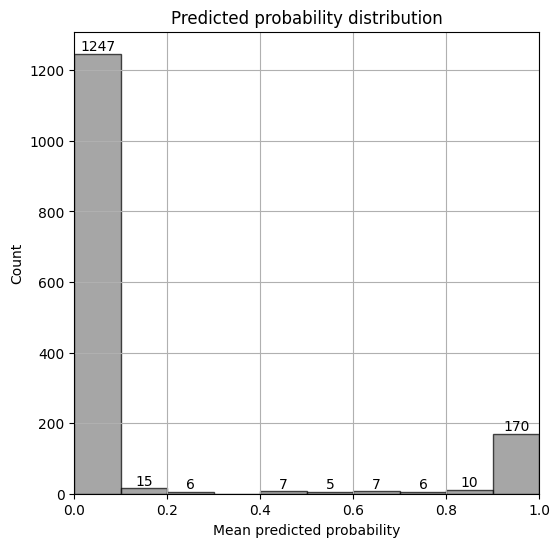

In [47]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(y_prob_after[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(y_prob_after[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

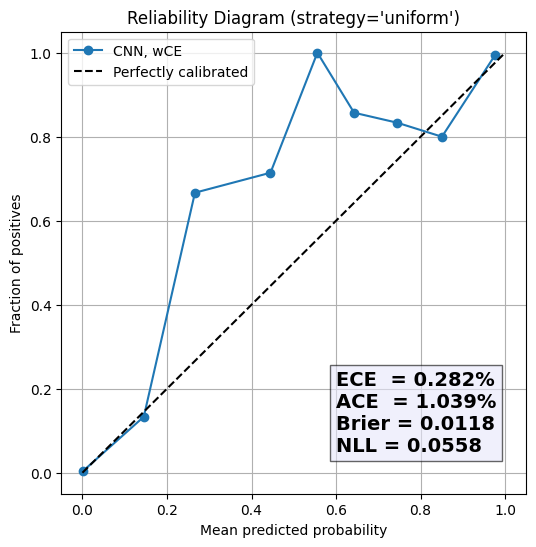

In [48]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_after, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_after[:, 1])
ace = adaptive_calibration_error(y_prob_after, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, wCE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

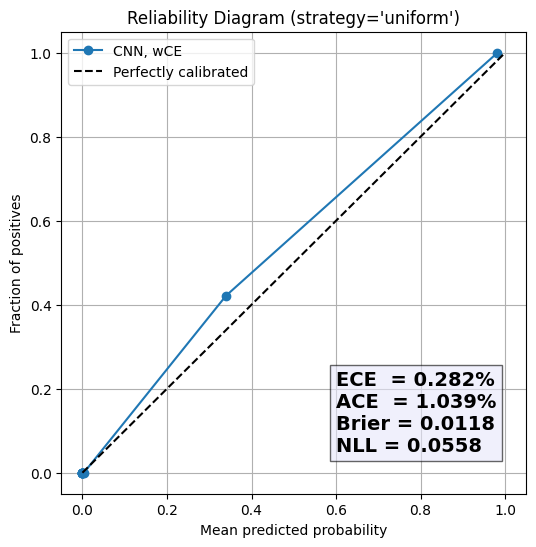

In [49]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, wCE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [50]:
ece, ece_rows = ece_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00282
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    12 | [  0.500,   0.600] |      0.555  |      0.583 |       0.028  |     0.00023
 6  |     7 | [  0.600,   0.700] |      0.643  |      0.857 |       0.214  |     0.00102
 7  |    12 | [  0.700,   0.800] |      0.739  |      0.583 |       0.156  |     0.00127
 8  |    25 | [  0.800,   0.900] |      0.853  |      0.840 |       0.013  |     0.00022
 9  |  1417 | [  0.900,   1.000] |      0.995  |      0.995 |       0.000  |     0.00008


In [51]:
ace, ace_rows = ace_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.01039

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.00381, 0.04139] |    0.018   |   0.000  |    0.018
 1  |   148 | [0.04145, 0.99047] |    0.662   |   0.581  |    0.081
 2  |   148 | [0.99056, 0.99920] |    0.997   |   1.000  |    0.003
 3  |   148 | [0.99921, 0.99995] |    1.000   |   1.000  |    0.000
 4  |   148 | [0.99995, 1.00000] |    1.000   |   1.000  |    0.000
 5  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 6  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 7  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 8  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 9  |   141 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Platt Scaling

In [32]:
s_val = logits_val[:, 1] - logits_val[:, 0]
s_test = logits_test[:, 1] - logits_test[:, 0]
lr = LogisticRegression(solver='lbfgs')
lr.fit(s_val.reshape(-1, 1), y_val)
calibrated_probs = lr.predict_proba(s_test.reshape(-1, 1))
calibrated_probs.shape

(1473, 2)

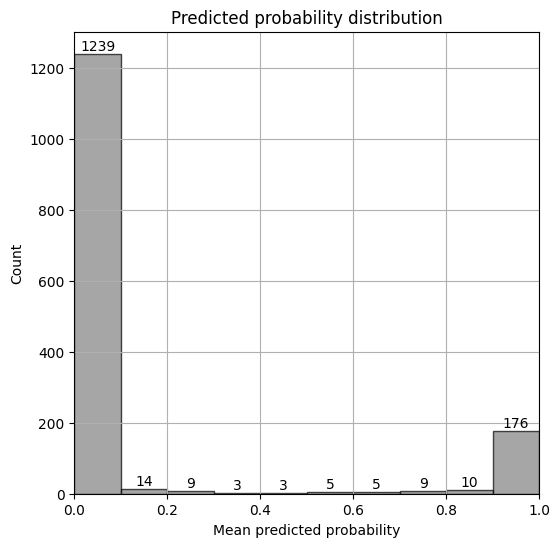

In [33]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(calibrated_probs[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(calibrated_probs[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

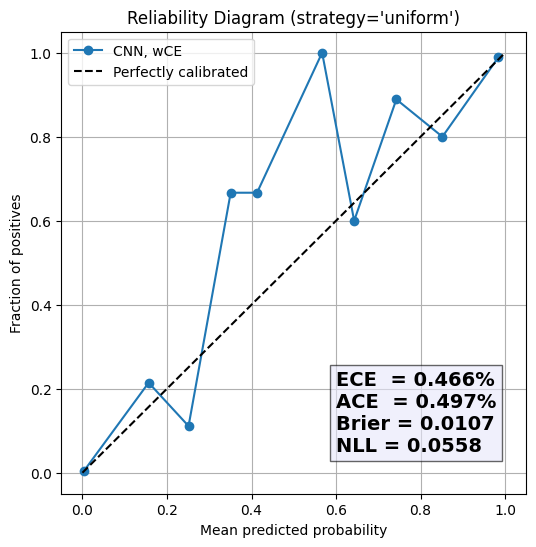

In [34]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, calibrated_probs[:, 1])
ace = adaptive_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, wCE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

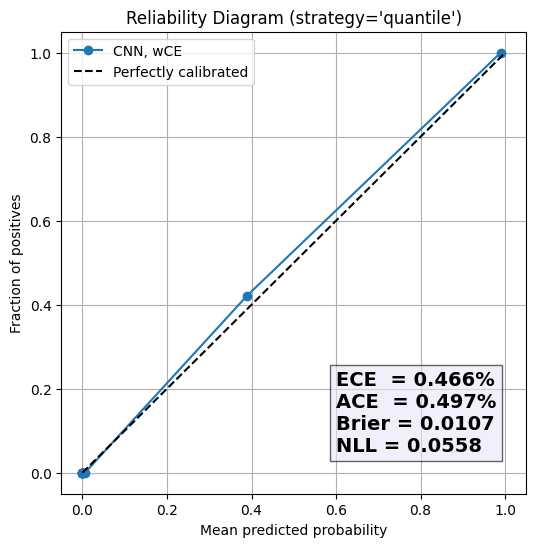

In [35]:
prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, wCE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [36]:
ece, ece_rows = ece_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00466
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |     8 | [  0.500,   0.600] |      0.575  |      0.750 |       0.175  |     0.00095
 6  |     8 | [  0.600,   0.700] |      0.645  |      0.500 |       0.145  |     0.00079
 7  |    18 | [  0.700,   0.800] |      0.746  |      0.889 |       0.143  |     0.00175
 8  |    24 | [  0.800,   0.900] |      0.847  |      0.792 |       0.055  |     0.00090
 9  |  1415 | [  0.900,   1.000] |      0.995  |      0.996 |       0.000  |     0.00027


In [37]:
ace, ace_rows = ace_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00497

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.00221, 0.02449] |    0.011   |   0.000  |    0.011
 1  |   148 | [0.02453, 0.98393] |    0.613   |   0.581  |    0.032
 2  |   148 | [0.98409, 0.99865] |    0.994   |   1.000  |    0.006
 3  |   148 | [0.99866, 0.99991] |    1.000   |   1.000  |    0.000
 4  |   148 | [0.99991, 1.00000] |    1.000   |   1.000  |    0.000
 5  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 6  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 7  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 8  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 9  |   141 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Isotonic Regression

In [38]:
p_val = torch.softmax(logits_val, dim=1).detach().cpu().numpy()[:, 1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_val, y_val)

p_test = torch.softmax(logits_test, dim=1).detach().cpu().numpy()[:, 1]
p_test_cal = iso.transform(p_test)
p_test_calibrated = np.column_stack([1 - p_test_cal, p_test_cal])  


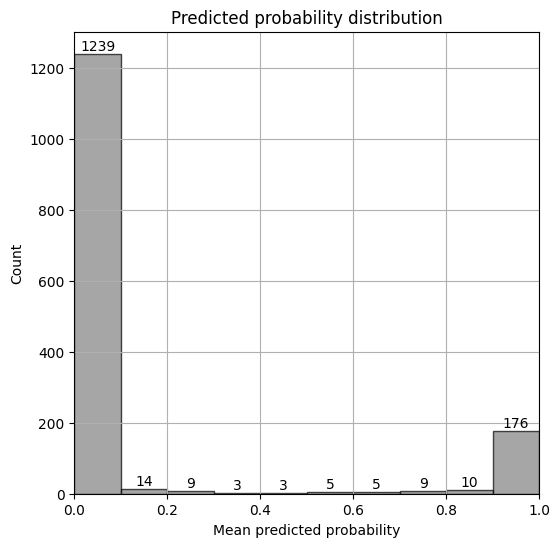

In [39]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(calibrated_probs[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(calibrated_probs[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

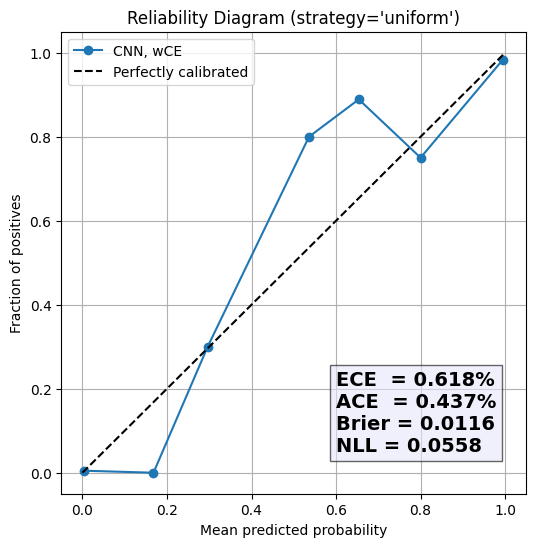

In [40]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, p_test_calibrated[:, 1])
ace = adaptive_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='uniform')
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, wCE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

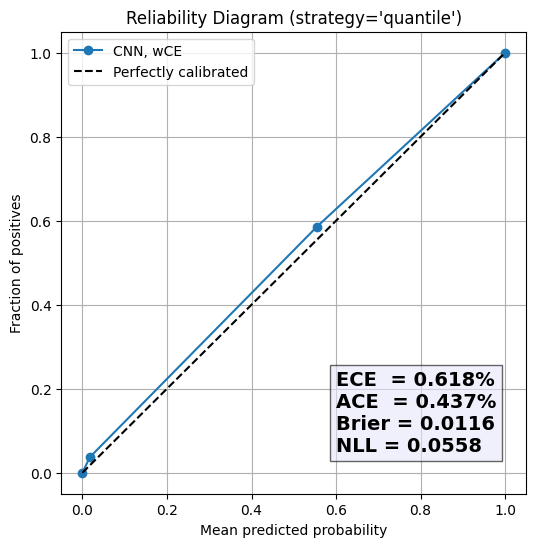

In [41]:
prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, wCE')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [42]:
ece, ece_rows = ece_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00618
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    10 | [  0.500,   0.600] |      0.536  |      0.800 |       0.264  |     0.00179
 6  |     9 | [  0.600,   0.700] |      0.654  |      0.889 |       0.235  |     0.00144
 7  |    20 | [  0.700,   0.800] |      0.704  |      0.700 |       0.004  |     0.00005
 8  |     5 | [  0.800,   0.900] |      0.806  |      0.800 |       0.006  |     0.00002
 9  |  1429 | [  0.900,   1.000] |      0.997  |      0.994 |       0.003  |     0.00288


In [43]:
ace, ace_rows = ace_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00437

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.00000, 0.02326] |    0.001   |   0.014  |    0.012
 1  |   148 | [0.02326, 0.98246] |    0.613   |   0.574  |    0.039
 2  |   148 | [0.98246, 1.00000] |    0.998   |   0.993  |    0.005
 3  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 4  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 5  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 6  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 7  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 8  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 9  |   141 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

# InceptionTime + PU Loss

In [236]:
from tsai.all import *
from pu_loss import PULossWrapped

criterion = PULossWrapped(prior=2*positive_prior, nnPU=True)

X_all = np.concatenate([X_train, X_val]).astype(np.float32)
y_all = np.concatenate([y_train_pu, y_val])

splits = (list(range(len(y_train_pu))),
          list(range(len(y_train_pu), len(y_all))))

tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)

clf = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus", #arch_config=dict(fc_dropout=0.3),
                   tfms=tfms, batch_tfms=batch_tfms,train_metrics=True, loss_func=criterion,
                   metrics=accuracy, cbs=ShowGraph(), wd=1e-3)

In [237]:
clf.load("har_inctime_nnPU")

In [238]:
X_all = X_all.reshape(X_all.shape[0], 1, X_all.shape[1])
X_all.shape

(8826, 1, 561)

In [245]:
# Train metrics

logits_train, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds_train = logits_train.argmax(dim=-1)
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9986    0.9898    0.9942      6366
           1     0.9376    0.9909    0.9635       986

    accuracy                         0.9899      7352
   macro avg     0.9681    0.9903    0.9788      7352
weighted avg     0.9904    0.9899    0.9901      7352

[[6301   65]
 [   9  977]]


In [246]:
logits_val, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds_val = logits_val.argmax(dim=-1)
print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9805    0.9929    0.9866      1264
           1     0.9536    0.8810    0.9158       210

    accuracy                         0.9769      1474
   macro avg     0.9670    0.9369    0.9512      1474
weighted avg     0.9766    0.9769    0.9765      1474

[[1255    9]
 [  25  185]]


In [247]:
logits_test, target = clf.get_X_preds(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]), y_test_pu, with_decoded=False)
preds_test = logits_test.argmax(dim=-1)
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9790    0.9952    0.9870      1263
           1     0.9683    0.8714    0.9173       210

    accuracy                         0.9776      1473
   macro avg     0.9736    0.9333    0.9522      1473
weighted avg     0.9774    0.9776    0.9771      1473

[[1257    6]
 [  27  183]]


In [248]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of true positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of true positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of true positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")


Train
Total number of true positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 487
In percentage: 0.9878
Test
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 92
In percentage: 0.8762
Val
Total number of true positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 93
In percentage: 0.8857


## Calibration

In [249]:
y_prob_before = torch.softmax(torch.tensor(logits_test), dim=1).numpy()
n_bins = 10
y_prob_before

array([[0.96862876, 0.03137127],
       [0.95137995, 0.04862005],
       [0.94039583, 0.05960415],
       ...,
       [0.37665156, 0.6233484 ],
       [0.9562626 , 0.04373735],
       [0.19006012, 0.80993986]], shape=(1473, 2), dtype=float32)

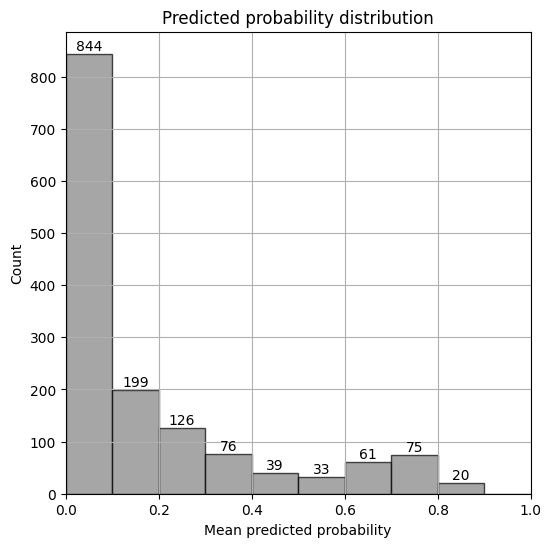

In [250]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(y_prob_before[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(y_prob_before[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

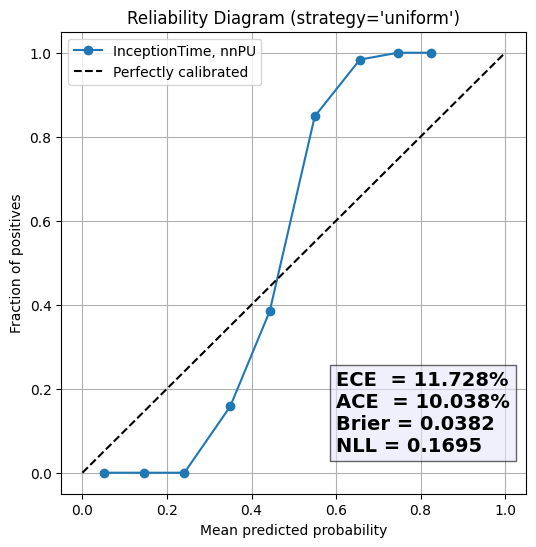

In [251]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_before, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_before[:, 1])
ace = adaptive_calibration_error(y_prob_before, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, nnPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

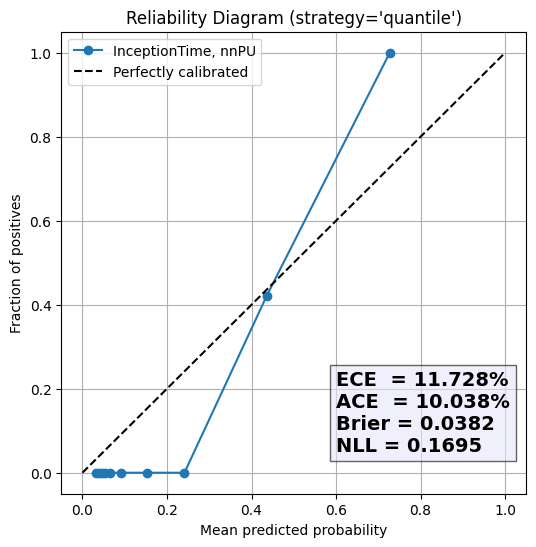

In [252]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, nnPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

## Temperature Scaling

In [253]:
from calibration import *
scaled_model = ModelWithTemperature(clf)
scaled_model.set_temperature(logits_val, y_val)

Optimal temperature: 0.238


ModelWithTemperature()

In [260]:
scaled_logits_test = scaled_model.temperature_scale(logits_test)
y_prob_after = torch.softmax(torch.tensor(scaled_logits_test), dim=1).numpy()

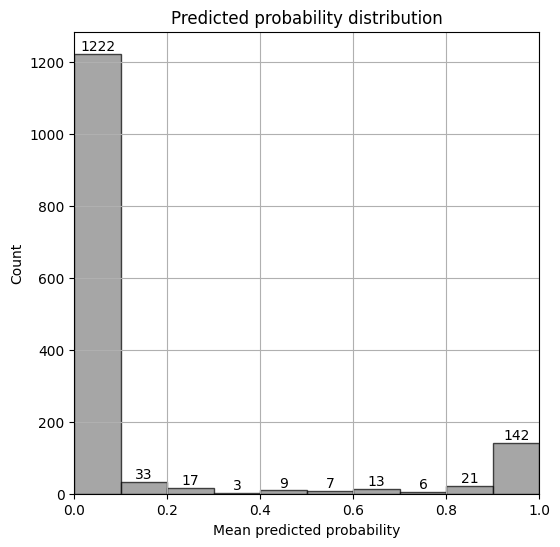

In [261]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(y_prob_after[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(y_prob_after[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

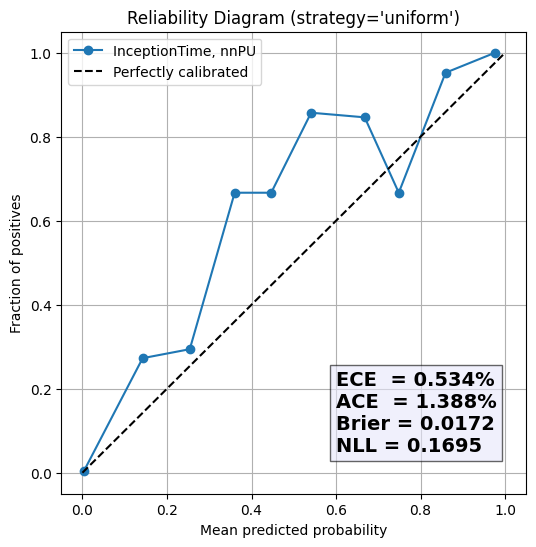

In [262]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_after, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_after[:, 1])
ace = adaptive_calibration_error(y_prob_after, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, nnPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

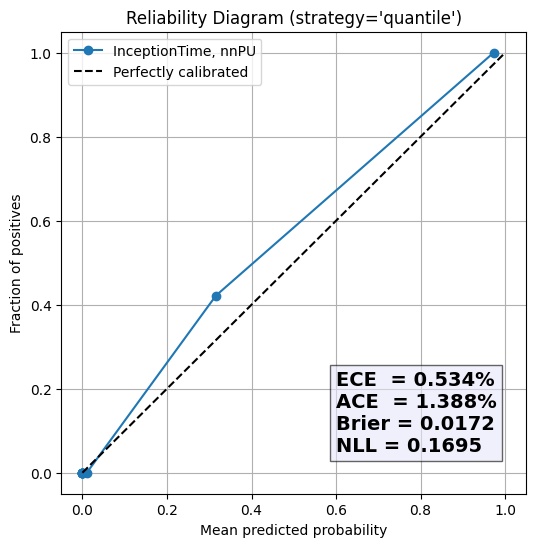

In [263]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, nnPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [264]:
ece, ece_rows = ece_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00534
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    16 | [  0.500,   0.600] |      0.548  |      0.562 |       0.014  |     0.00016
 6  |    16 | [  0.600,   0.700] |      0.662  |      0.750 |       0.088  |     0.00095
 7  |    23 | [  0.700,   0.800] |      0.747  |      0.696 |       0.051  |     0.00080
 8  |    54 | [  0.800,   0.900] |      0.858  |      0.815 |       0.043  |     0.00159
 9  |  1364 | [  0.900,   1.000] |      0.994  |      0.996 |       0.002  |     0.00185


In [265]:
ace, ace_rows = ace_breakdown(y_test, y_prob_after, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.01388

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.00046, 0.11921] |    0.027   |   0.000  |    0.027
 1  |   148 | [0.12178, 0.96845] |    0.686   |   0.581  |    0.105
 2  |   148 | [0.96858, 0.99767] |    0.990   |   1.000  |    0.010
 3  |   148 | [0.99770, 0.99978] |    0.999   |   1.000  |    0.001
 4  |   148 | [0.99979, 0.99998] |    1.000   |   1.000  |    0.000
 5  |   148 | [0.99998, 0.99999] |    1.000   |   1.000  |    0.000
 6  |   148 | [0.99999, 1.00000] |    1.000   |   1.000  |    0.000
 7  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 8  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 9  |   141 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Platt Scaling

In [266]:
s_val = logits_val[:, 1] - logits_val[:, 0]
s_test = logits_test[:, 1] - logits_test[:, 0]
lr = LogisticRegression(solver='lbfgs')
lr.fit(s_val.reshape(-1, 1), y_val)
calibrated_probs = lr.predict_proba(s_test.reshape(-1, 1))
calibrated_probs.shape

(1473, 2)

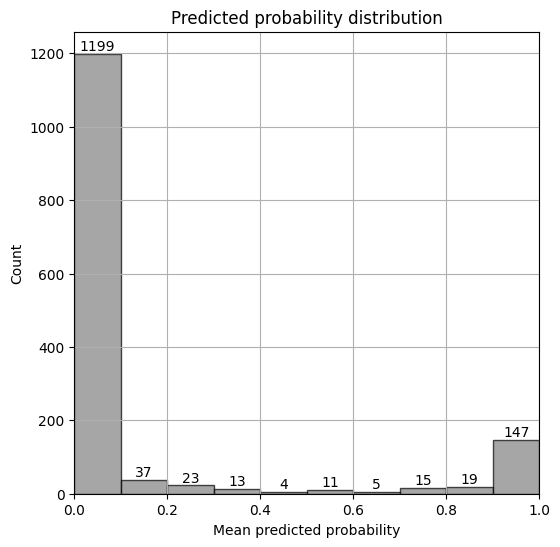

In [267]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(calibrated_probs[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(calibrated_probs[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

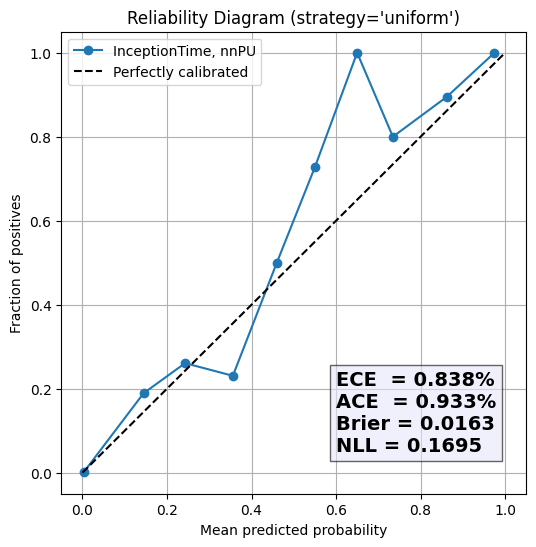

In [268]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, calibrated_probs[:, 1])
ace = adaptive_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, nnPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

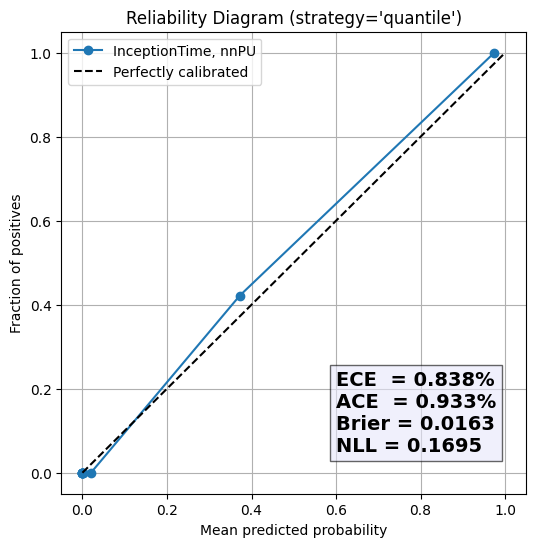

In [269]:
prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, nnPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [270]:
ece, ece_rows = ece_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.4f}  |  {weighted:10.5f}")

ECE = 0.00838
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    15 | [  0.500,   0.600] |      0.547  |      0.667 |      0.1194  |     0.00122
 6  |    18 | [  0.600,   0.700] |      0.646  |      0.833 |      0.1876  |     0.00229
 7  |    38 | [  0.700,   0.800] |      0.748  |      0.763 |      0.0150  |     0.00039
 8  |    56 | [  0.800,   0.900] |      0.857  |      0.839 |      0.0182  |     0.00069
 9  |  1346 | [  0.900,   1.000] |      0.994  |      0.998 |      0.0041  |     0.00379


In [271]:
ace, ace_rows = ace_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.4f}")
    print()

ACE = 0.00933

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.00063, 0.10359] |    0.026   |   0.000  |   0.0257
 1  |   148 | [0.10567, 0.94344] |    0.630   |   0.581  |   0.0488
 2  |   148 | [0.94365, 0.99468] |    0.980   |   1.000  |   0.0198
 3  |   148 | [0.99474, 0.99939] |    0.998   |   1.000  |   0.0021
 4  |   148 | [0.99942, 0.99992] |    1.000   |   1.000  |   0.0002
 5  |   148 | [0.99992, 0.99997] |    1.000   |   1.000  |   0.0001
 6  |   148 | [0.99997, 0.99998] |    1.000   |   1.000  |   0.0000
 7  |   148 | [0.99998, 0.99999] |    1.000   |   1.000  |   0.0000
 8  |   148 | [0.99999, 1.00000] |    1.000   |   1.000  |   0.0000
 9  |   141 | [1.00000, 1.00000] |    1.000   |   1.000  |   0.0000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Isotonic Regression

In [272]:
p_val = torch.softmax(logits_val, dim=1).detach().cpu().numpy()[:, 1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_val, y_val)

p_test = torch.softmax(logits_test, dim=1).detach().cpu().numpy()[:, 1]
p_test_cal = iso.transform(p_test)
p_test_calibrated = np.column_stack([1 - p_test_cal, p_test_cal])  


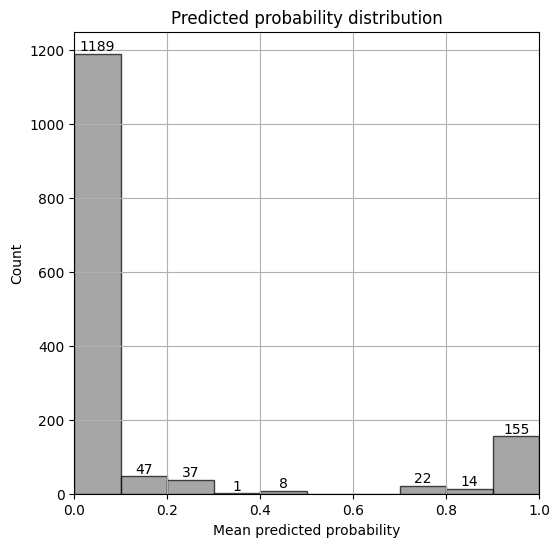

In [273]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(p_test_calibrated[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(p_test_calibrated[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

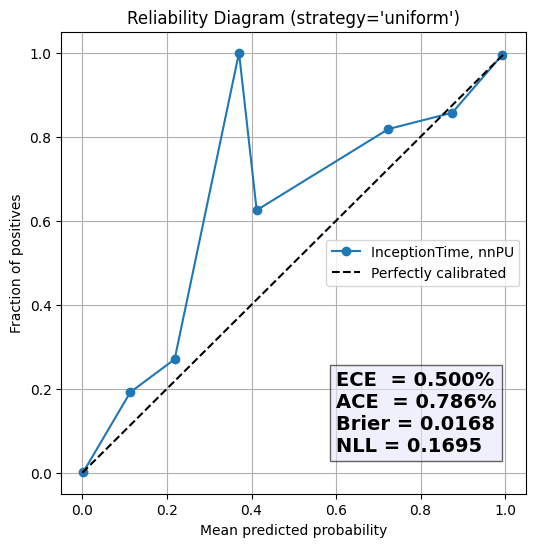

In [274]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, p_test_calibrated[:, 1])
ace = adaptive_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='uniform')
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, nnPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

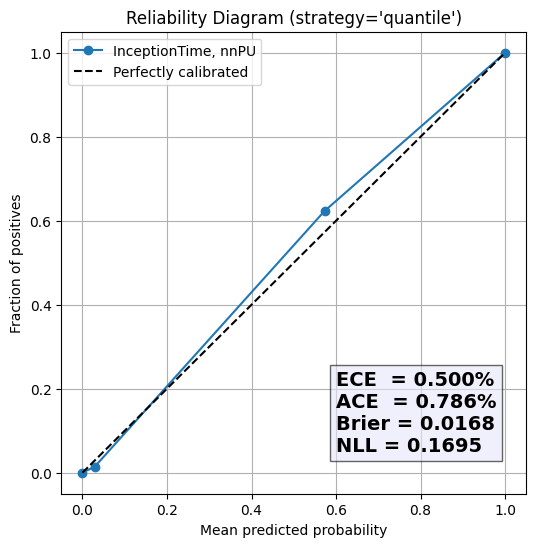

In [275]:
prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, nnPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [276]:
ece, ece_rows = ece_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00500
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |     8 | [  0.500,   0.600] |      0.588  |      0.375 |       0.213  |     0.00116
 6  |     1 | [  0.600,   0.700] |      0.630  |      0.000 |       0.630  |     0.00043
 7  |    57 | [  0.700,   0.800] |      0.759  |      0.754 |       0.004  |     0.00017
 8  |    63 | [  0.800,   0.900] |      0.881  |      0.825 |       0.056  |     0.00240
 9  |  1344 | [  0.900,   1.000] |      0.998  |      0.999 |       0.001  |     0.00086


In [277]:
ace, ace_rows = ace_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00786

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.00000, 0.01754] |    0.007   |   0.007  |    0.001
 1  |   148 | [0.01754, 0.91667] |    0.641   |   0.574  |    0.067
 2  |   148 | [0.91667, 1.00000] |    0.993   |   1.000  |    0.007
 3  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 4  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 5  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 6  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 7  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 8  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 9  |   141 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

# Mamba2 + PU Loss

In [279]:
batch_size = 128
in_channel = X_train_tensor.shape[1]
seq_length = X_train_tensor.shape[2]
print(f'in_channel: {in_channel}, sequence_length: {seq_length}')
n_hidden = 64

in_channel: 1, sequence_length: 561


In [280]:
from baseline import Mamba2Classifier
model_mamba = Mamba2Classifier(in_channel, hidden_dim=256, num_classes=1, num_layers=2, dropout=0.4)
model_mamba = model_mamba.to(device)
print(model_mamba)

256 2 64
256 2 64
Mamba2Classifier(
  (input_proj): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (input_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, out_features=256, bias=False)
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.4, inplace=False)
    )
    (1): Mamba2Block(
      (mamba): Mamba2(
        (in_proj): Linear(in_features=256, out_features=1288, bias=False)
        (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
        (act): SiLU()
        (norm): RMSNorm()
        (out_proj): Linear(in_features=512, ou

In [281]:
model_mamba.load_state_dict(torch.load("models/har_mamba2_convproj_uPU.pth", weights_only=True))

<All keys matched successfully>

In [282]:
X_test_tensor_perm = X_test_tensor.permute(0, 2, 1)
test_dataset = TensorDataset(X_test_tensor_perm, torch.tensor(y_test_pu, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=64)  

X_val_tensor_perm = X_val_tensor.permute(0, 2, 1)
val_dataset = TensorDataset(X_val_tensor_perm, torch.tensor(y_val_pu, dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=64)  

X_train_tensor_perm = X_train_tensor.permute(0, 2, 1)
train_dataset = TensorDataset(X_train_tensor_perm, torch.tensor(y_train_pu, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64)  
print(X_test_tensor_perm.shape)
print(X_train_tensor_perm.shape)

torch.Size([1473, 561, 1])
torch.Size([7352, 561, 1])


In [283]:
preds_train = []
logits_train = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).long().view(-1)
        preds_train.append(preds.cpu())
        logits_train.append(probs.cpu())

# Concatenate all predictions
preds_train = torch.cat(preds_train).numpy()
logits_train = torch.cat(logits_train)

print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9795    0.9964    0.9879      6366
           1     0.9737    0.8651    0.9162       986

    accuracy                         0.9788      7352
   macro avg     0.9766    0.9307    0.9520      7352
weighted avg     0.9787    0.9788    0.9782      7352

[[6343   23]
 [ 133  853]]


In [284]:
preds_val = []
logits_val = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in val_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).long().view(-1)
        preds_val.append(preds.cpu())
        logits_val.append(probs.cpu())

# Concatenate all predictions
preds_val = torch.cat(preds_val).numpy()
logits_val = torch.cat(logits_val)

print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9601    0.9897    0.9747      1264
           1     0.9240    0.7524    0.8294       210

    accuracy                         0.9559      1474
   macro avg     0.9420    0.8710    0.9020      1474
weighted avg     0.9549    0.9559    0.9540      1474

[[1251   13]
 [  52  158]]


In [285]:
preds_test = []
logits_test = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).long().view(-1)
        preds_test.append(preds.cpu())
        logits_test.append(probs.cpu())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()
logits_test = torch.cat(logits_test)
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9602    0.9921    0.9759      1263
           1     0.9405    0.7524    0.8360       210

    accuracy                         0.9579      1473
   macro avg     0.9503    0.8722    0.9059      1473
weighted avg     0.9573    0.9579    0.9559      1473

[[1253   10]
 [  52  158]]


In [286]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")


Train
Total number of positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 411
In percentage: 0.8337
Val
Total number of positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 85
In percentage: 0.8095
Test
Total number of positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 77
In percentage: 0.7333


## Calibration

In [287]:
logits_train = torch.cat([torch.zeros_like(logits_train), logits_train], dim=1)
logits_val = torch.cat([torch.zeros_like(logits_val), logits_val], dim=1)
logits_test = torch.cat([torch.zeros_like(logits_test), logits_test], dim=1)

In [288]:
y_prob_before = torch.softmax(torch.tensor(logits_test), dim=1).numpy()
y_prob_before

array([[0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       ...,
       [0.26894143, 0.7310586 ],
       [0.5       , 0.5       ],
       [0.26894143, 0.7310586 ]], shape=(1473, 2), dtype=float32)

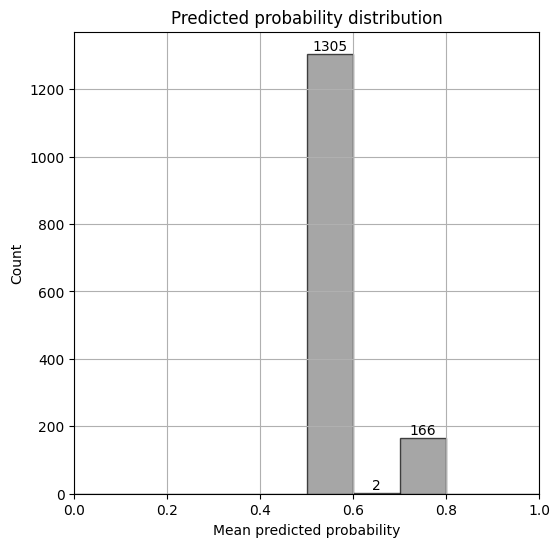

In [289]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(y_prob_before[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(y_prob_before[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

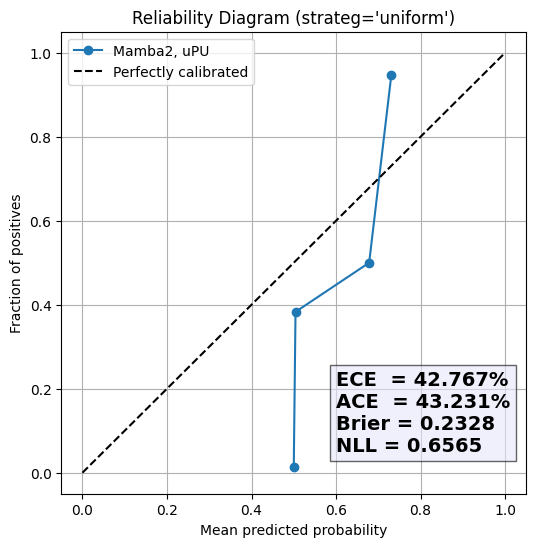

In [290]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_before, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_before[:, 1])
ace = adaptive_calibration_error(y_prob_before, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, uPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strateg=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

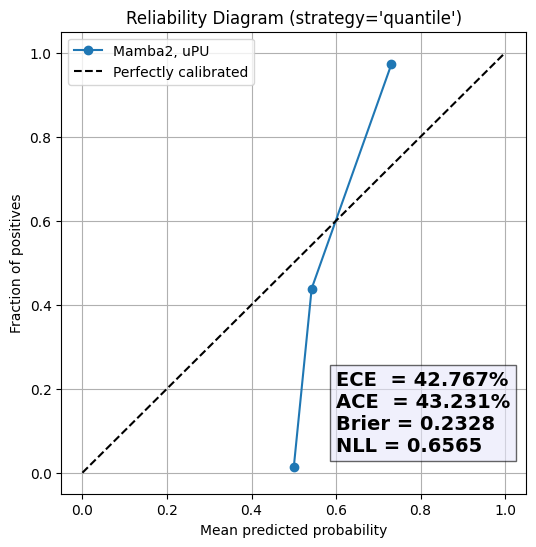

In [291]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, uPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

## Temperature Scaling

In [292]:
scaled_model = ModelWithTemperature(model_mamba)
scaled_model.set_temperature(logits_val, y_val)

Optimal temperature: 0.395


ModelWithTemperature(
  (model): Mamba2Classifier(
    (input_proj): Conv1d(1, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (input_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (blocks): Sequential(
      (0): Mamba2Block(
        (mamba): Mamba2(
          (in_proj): Linear(in_features=256, out_features=1288, bias=False)
          (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
          (act): SiLU()
          (norm): RMSNorm()
          (out_proj): Linear(in_features=512, out_features=256, bias=False)
        )
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.4, inplace=False)
      )
      (1): Mamba2Block(
        (mamba): Mamba2(
          (in_proj): Linear(in_features=256, out_features=1288, bias=False)
          (conv1d): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)
          (act): SiLU()
          (norm): R

In [293]:
scaled_logits_test = scaled_model.temperature_scale(logits_test)
y_prob_after = torch.softmax(torch.tensor(scaled_logits_test), dim=1).numpy()

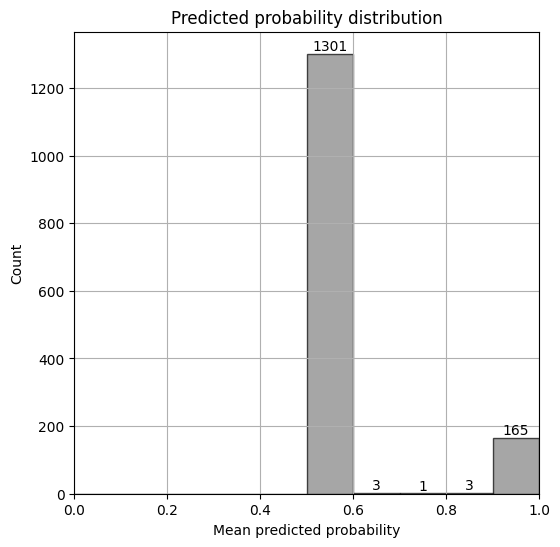

In [294]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(y_prob_after[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(y_prob_after[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

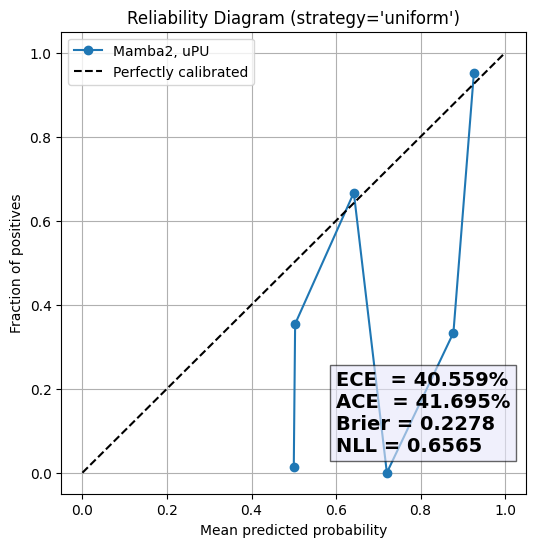

In [296]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_after, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_after[:, 1])
ace = adaptive_calibration_error(y_prob_after, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, uPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

## Platt Scaling

In [297]:
s_val = logits_val[:, 1] - logits_val[:, 0]
s_test = logits_test[:, 1] - logits_test[:, 0]
lr = LogisticRegression(solver='lbfgs')
lr.fit(s_val.reshape(-1, 1), y_val)
calibrated_probs = lr.predict_proba(s_test.reshape(-1, 1))
calibrated_probs.shape

(1473, 2)

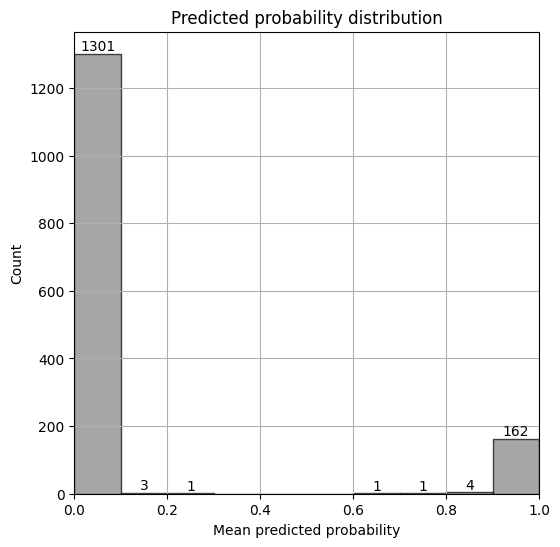

In [298]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(calibrated_probs[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(calibrated_probs[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

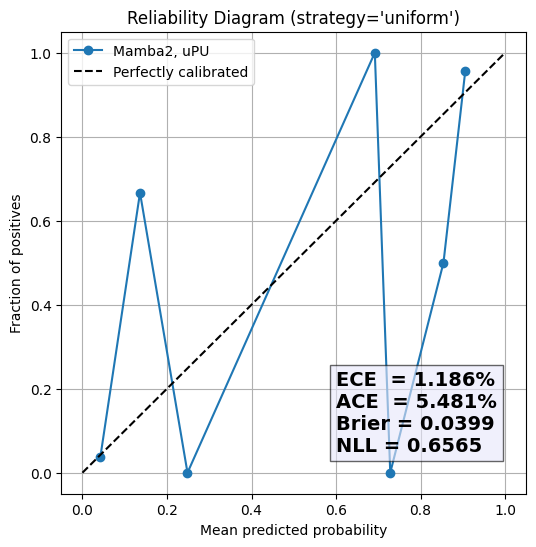

In [299]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, calibrated_probs[:, 1])
ace = adaptive_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, uPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

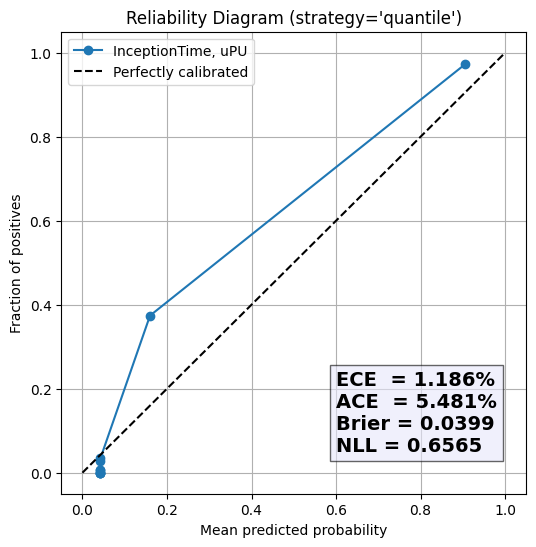

In [300]:
prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='InceptionTime, uPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [301]:
ece, ece_rows = ece_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.01186
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 6  |     1 | [  0.600,   0.700] |      0.692  |      1.000 |       0.308  |     0.00021
 7  |     2 | [  0.700,   0.800] |      0.740  |      0.500 |       0.240  |     0.00033
 8  |     7 | [  0.800,   0.900] |      0.858  |      0.429 |       0.430  |     0.00204
 9  |  1463 | [  0.900,   1.000] |      0.952  |      0.961 |       0.009  |     0.00929


In [302]:
ace, ace_rows = ace_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.05481

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.09423, 0.09423] |    0.094   |   0.027  |    0.067
 1  |   148 | [0.09423, 0.95752] |    0.841   |   0.628  |    0.212
 2  |   148 | [0.95752, 0.95752] |    0.958   |   0.959  |    0.002
 3  |   148 | [0.95752, 0.95752] |    0.958   |   0.980  |    0.022
 4  |   148 | [0.95752, 0.95752] |    0.958   |   0.993  |    0.036
 5  |   148 | [0.95752, 0.95752] |    0.958   |   1.000  |    0.042
 6  |   148 | [0.95752, 0.95752] |    0.958   |   0.993  |    0.036
 7  |   148 | [0.95752, 0.95752] |    0.958   |   1.000  |    0.042
 8  |   148 | [0.95752, 0.95752] |    0.958   |   1.000  |    0.042
 9  |   141 | [0.95752, 0.95752] |    0.958   |   1.000  |    0.042

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Isotonic Regression

In [303]:
p_val = torch.softmax(logits_val, dim=1).detach().cpu().numpy()[:, 1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_val, y_val)

p_test = torch.softmax(logits_test, dim=1).detach().cpu().numpy()[:, 1]
p_test_cal = iso.transform(p_test)
p_test_calibrated = np.column_stack([1 - p_test_cal, p_test_cal])  

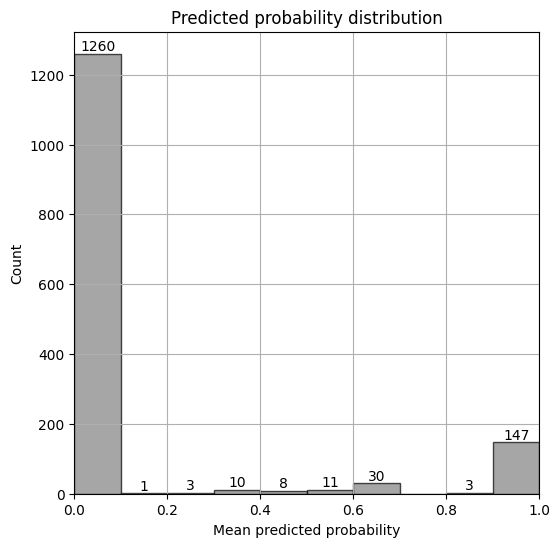

In [304]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(p_test_calibrated[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(p_test_calibrated[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

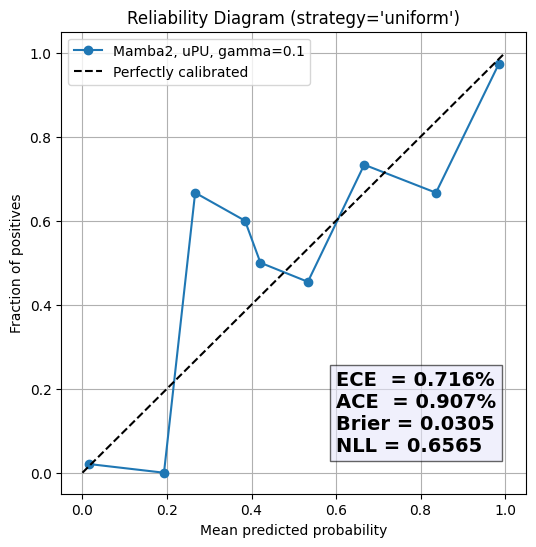

In [305]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, p_test_calibrated[:, 1])
ace = adaptive_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='uniform')
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, uPU, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

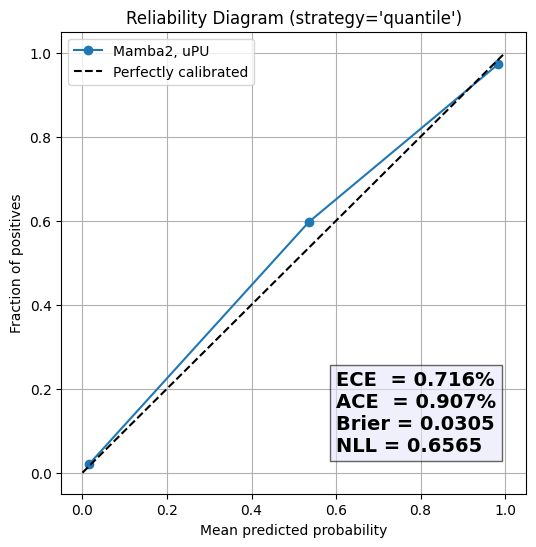

In [306]:
prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='Mamba2, uPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [307]:
ece, ece_rows = ece_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00716
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    19 | [  0.500,   0.600] |      0.553  |      0.474 |       0.079  |     0.00102
 6  |    40 | [  0.600,   0.700] |      0.654  |      0.650 |       0.004  |     0.00010
 7  |     3 | [  0.700,   0.800] |      0.733  |      0.333 |       0.400  |     0.00081
 8  |     4 | [  0.800,   0.900] |      0.829  |      0.750 |       0.079  |     0.00021
 9  |  1407 | [  0.900,   1.000] |      0.984  |      0.979 |       0.005  |     0.00501


In [308]:
ace, ace_rows = ace_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00907

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.01429, 0.15770] |    0.016   |   0.027  |    0.011
 1  |   148 | [0.16667, 0.98392] |    0.749   |   0.723  |    0.026
 2  |   148 | [0.98392, 0.98392] |    0.984   |   0.980  |    0.004
 3  |   148 | [0.98392, 0.98392] |    0.984   |   0.980  |    0.004
 4  |   148 | [0.98392, 0.98392] |    0.984   |   0.980  |    0.004
 5  |   148 | [0.98392, 0.98392] |    0.984   |   0.973  |    0.011
 6  |   148 | [0.98392, 0.98392] |    0.984   |   0.993  |    0.009
 7  |   148 | [0.98392, 0.98392] |    0.984   |   0.980  |    0.004
 8  |   148 | [0.98392, 0.98392] |    0.984   |   0.966  |    0.018
 9  |   141 | [0.98392, 0.98392] |    0.984   |   0.979  |    0.005

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

# CNN + PU Loss

In [318]:
batch_size = 64
print(X_train_tensor.shape)
train_dataset = TensorDataset(X_train_tensor, y_train_pu_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_pu_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_pu_tensor)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([7352, 1, 561])


In [319]:
from baseline import Conv_Net
model = Conv_Net(in_channel, seq_length, n_hidden, n_output=1, dropout=0.2)
model = model.to(device)

In [320]:
model.load_state_dict(torch.load("models/har_cnn_uPU.pth", weights_only=True))

<All keys matched successfully>

In [321]:
model.eval()
with torch.no_grad():
    logits_train = model(X_train_tensor.to(device)).cpu()
    probs = torch.sigmoid(logits_train)
    preds_train = (probs > 0.5).long().view(-1)

print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9896    0.9984    0.9940      6366
           1     0.9892    0.9320    0.9598       986

    accuracy                         0.9895      7352
   macro avg     0.9894    0.9652    0.9769      7352
weighted avg     0.9895    0.9895    0.9894      7352

[[6356   10]
 [  67  919]]


In [322]:
model.eval()
with torch.no_grad():
    logits_val = model(X_val_tensor.to(device)).cpu()
    probs = torch.sigmoid(logits_val)
    preds_val = (probs > 0.5).long().view(-1)

print(classification_report(y_val, preds_val, digits=4))
print(confusion_matrix(y_val, preds_val))

              precision    recall  f1-score   support

           0     0.9656    0.9984    0.9817      1264
           1     0.9880    0.7857    0.8753       210

    accuracy                         0.9681      1474
   macro avg     0.9768    0.8921    0.9285      1474
weighted avg     0.9688    0.9681    0.9666      1474

[[1262    2]
 [  45  165]]


In [323]:
model.eval()
with torch.no_grad():
    logits_test = model(X_test_tensor.to(device)).cpu()
    probs = torch.sigmoid(logits_test)
    preds_test = (probs > 0.5).long().view(-1)

print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9641    0.9984    0.9809      1263
           1     0.9879    0.7762    0.8693       210

    accuracy                         0.9667      1473
   macro avg     0.9760    0.8873    0.9251      1473
weighted avg     0.9675    0.9667    0.9650      1473

[[1261    2]
 [  47  163]]


In [324]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Val")
correct_preds_num_val = (preds_val[unlabeled_idx_val] == y_val[unlabeled_idx_val]).sum()
print(f"Total number of positive sampels:{(y_val==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_val)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_val}\n\
In percentage: {(correct_preds_num_val/len(unlabeled_idx_val)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")


Train
Total number of positive sampels:986
Total number of unmarked positive sampels: 493
Number of unmarked samples correctly predicted as positive: 464
In percentage: 0.9412
Val
Total number of positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 84
In percentage: 0.8000
Test
Total number of positive sampels:210
Total number of unmarked positive sampels: 105
Number of unmarked samples correctly predicted as positive: 79
In percentage: 0.7524


## Calibration

In [325]:
logits_train = torch.cat([torch.zeros_like(logits_train), logits_train], dim=1)
logits_val = torch.cat([torch.zeros_like(logits_val), logits_val], dim=1)
logits_test = torch.cat([torch.zeros_like(logits_test), logits_test], dim=1)


In [326]:
y_prob_before = torch.softmax(torch.tensor(logits_test), dim=1).numpy()
y_prob_before

array([[9.9999440e-01, 5.6031904e-06],
       [9.9987864e-01, 1.2129932e-04],
       [9.9984789e-01, 1.5210423e-04],
       ...,
       [1.0872756e-01, 8.9127243e-01],
       [9.9967670e-01, 3.2336838e-04],
       [4.1018642e-02, 9.5898139e-01]], shape=(1473, 2), dtype=float32)

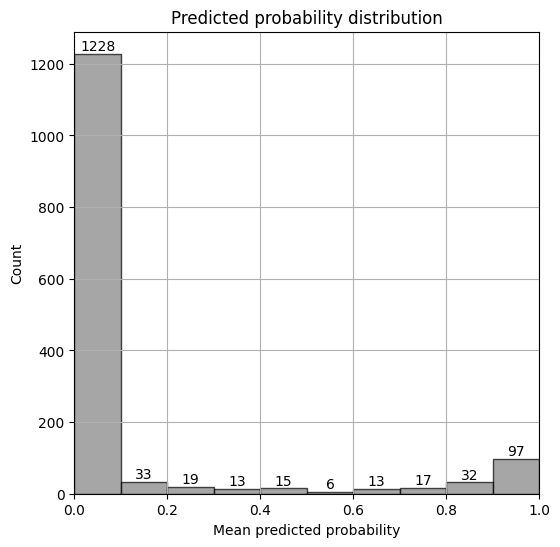

In [327]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(y_prob_before[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(y_prob_before[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

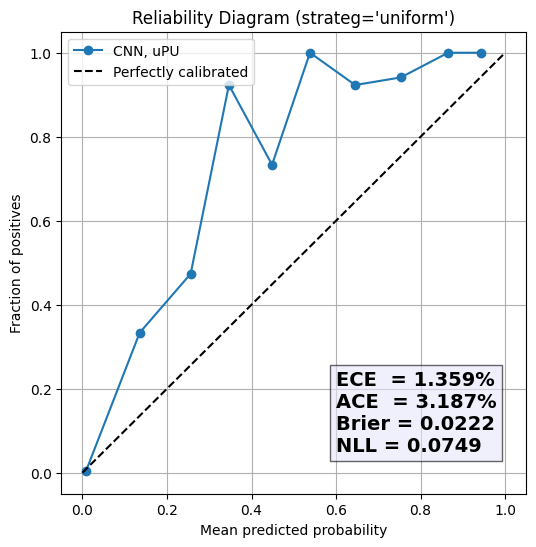

In [328]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_before, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_before[:, 1])
ace = adaptive_calibration_error(y_prob_before, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, uPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strateg=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

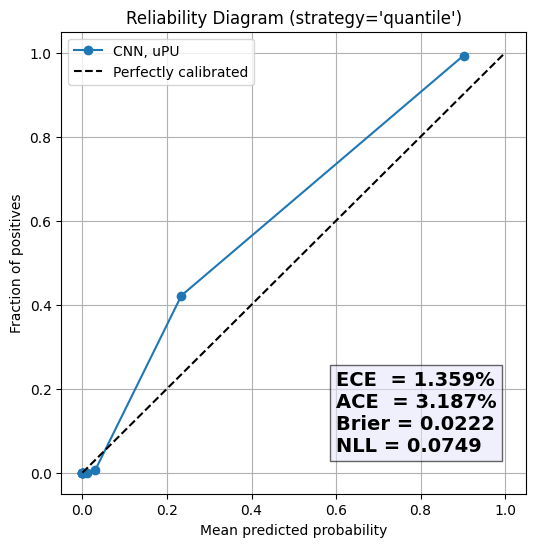

In [329]:
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, uPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

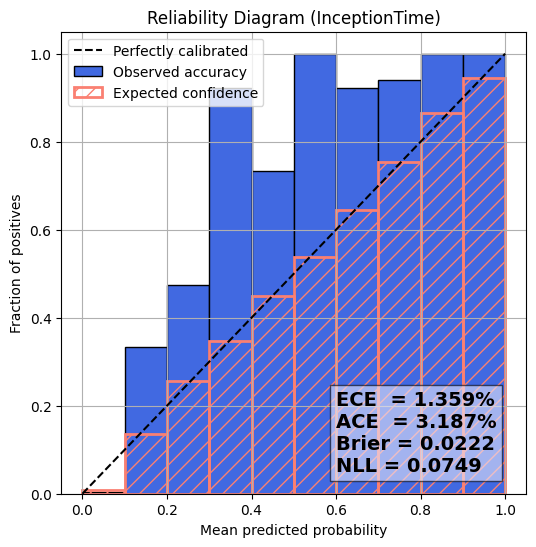

In [330]:
# equal-width binning
prob_true, prob_pred = calibration_curve(y_test, y_prob_before[:, 1], n_bins=10, strategy='uniform')
# Let n_bins be the number of bins you want
n_bins = 10
bins = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# When plotting bars
bin_width = bins[1] - bins[0]

plt.figure(figsize=(6,6))
plt.bar(bin_centers, prob_true, width=bin_width, color='royalblue', edgecolor='black', align='center', label='Observed accuracy')
plt.bar(bin_centers, prob_pred, width=bin_width, fill=False, edgecolor='salmon', linewidth=2, hatch='//', align='center', label='Expected confidence')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (InceptionTime)')
plt.legend()
plt.grid(True)
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

## Temperature Scaling

In [334]:
scaled_model = ModelWithTemperature(model)
scaled_model.set_temperature(logits_val, y_val)

Optimal temperature: 0.803


ModelWithTemperature(
  (model): Conv_Net(
    (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.2, inplace=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=17920, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=1, bias=True)
    (features): Sequential(
      (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU()
      (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.2, inplace=False)
    )
    (classifier): Sequential(
      (0): Linear(in_features=17920, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64,

In [337]:
scaled_logits_test = scaled_model.temperature_scale(logits_test)
y_prob_after = torch.softmax(torch.tensor(scaled_logits_test), dim=1).numpy()

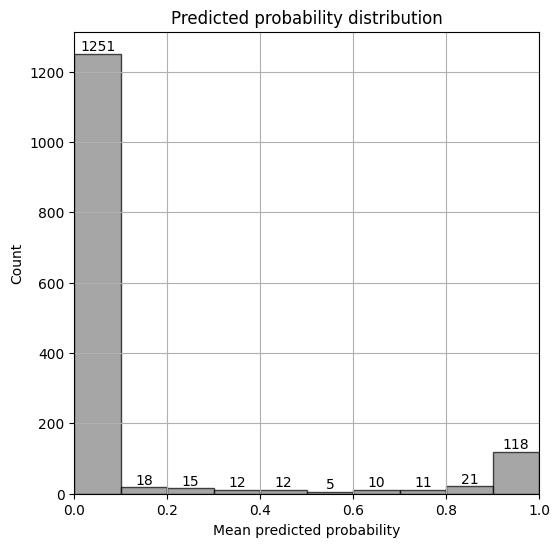

In [338]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(y_prob_after[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(y_prob_after[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

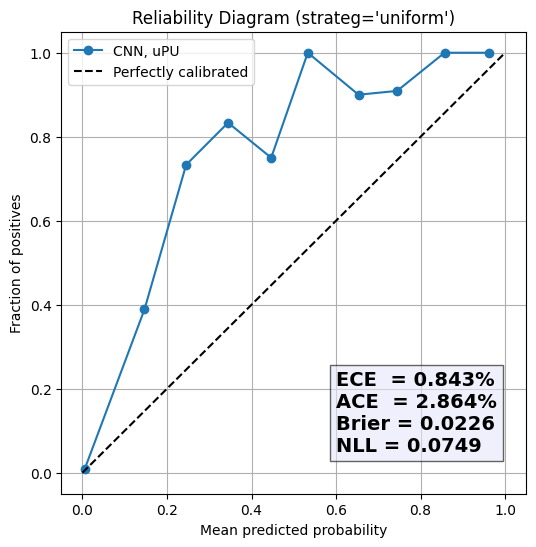

In [339]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(y_prob_after, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, y_prob_after[:, 1])
ace = adaptive_calibration_error(y_prob_after, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, y_prob_after[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, uPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strateg=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

## Platt Scaling

In [340]:
s_val = logits_val[:, 1] - logits_val[:, 0]
s_test = logits_test[:, 1] - logits_test[:, 0]
lr = LogisticRegression(solver='lbfgs')
lr.fit(s_val.reshape(-1, 1), y_val)
calibrated_probs = lr.predict_proba(s_test.reshape(-1, 1))
calibrated_probs.shape

(1473, 2)

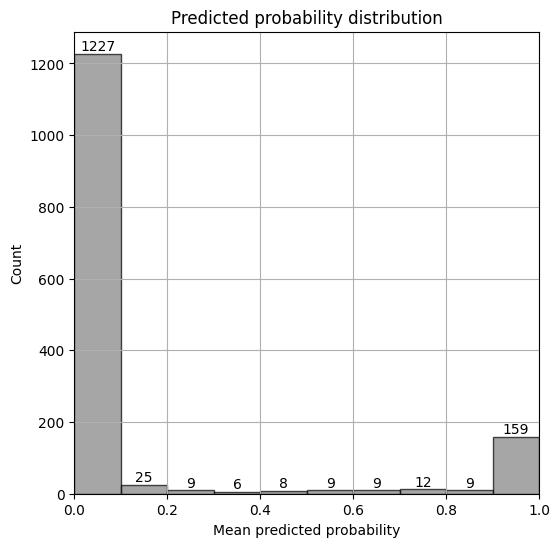

In [341]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(calibrated_probs[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(calibrated_probs[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

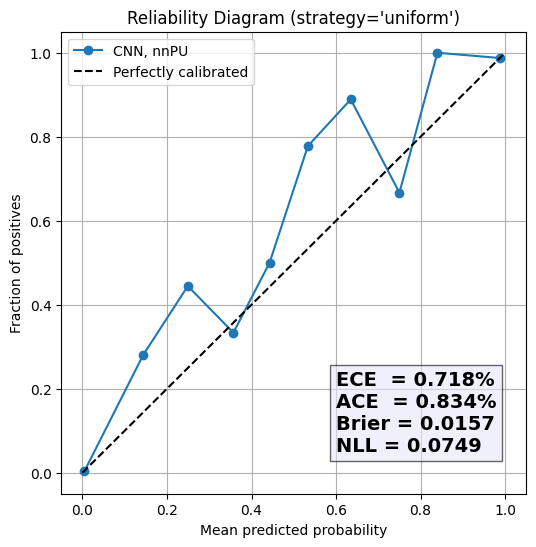

In [342]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, calibrated_probs[:, 1])
ace = adaptive_calibration_error(calibrated_probs, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='uniform')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, nnPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

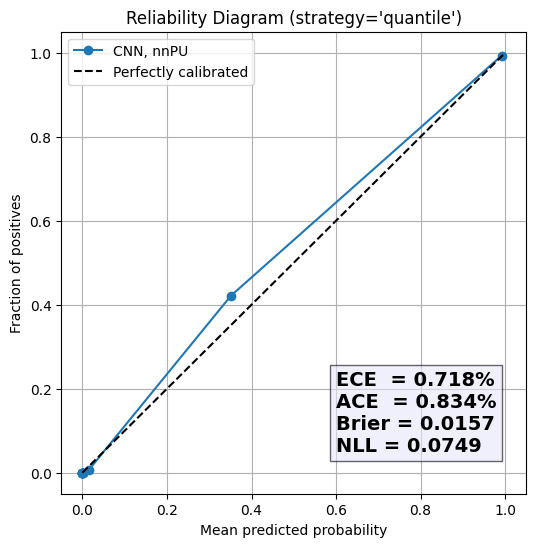

In [343]:
prob_true, prob_pred = calibration_curve(y_test, calibrated_probs[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, nnPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [344]:
ece, ece_rows = ece_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00718
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 5  |    17 | [  0.500,   0.600] |      0.545  |      0.647 |       0.102  |     0.00118
 6  |    15 | [  0.600,   0.700] |      0.638  |      0.800 |       0.162  |     0.00165
 7  |    21 | [  0.700,   0.800] |      0.750  |      0.619 |       0.131  |     0.00187
 8  |    34 | [  0.800,   0.900] |      0.852  |      0.794 |       0.058  |     0.00134
 9  |  1386 | [  0.900,   1.000] |      0.994  |      0.996 |       0.001  |     0.00114


In [345]:
ace, ace_rows = ace_breakdown(y_test, calibrated_probs, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00834

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.00100, 0.05681] |    0.008   |   0.007  |    0.001
 1  |   148 | [0.05839, 0.96422] |    0.650   |   0.581  |    0.069
 2  |   148 | [0.96600, 0.99572] |    0.985   |   0.993  |    0.008
 3  |   148 | [0.99575, 0.99922] |    0.998   |   1.000  |    0.002
 4  |   148 | [0.99924, 0.99998] |    1.000   |   1.000  |    0.000
 5  |   148 | [0.99998, 1.00000] |    1.000   |   1.000  |    0.000
 6  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 7  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 8  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 9  |   141 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

## Isotonic Regression

In [346]:
p_val = torch.softmax(logits_val, dim=1).detach().cpu().numpy()[:, 1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(p_val, y_val)

p_test = torch.softmax(logits_test, dim=1).detach().cpu().numpy()[:, 1]
p_test_cal = iso.transform(p_test)
p_test_calibrated = np.column_stack([1 - p_test_cal, p_test_cal])  

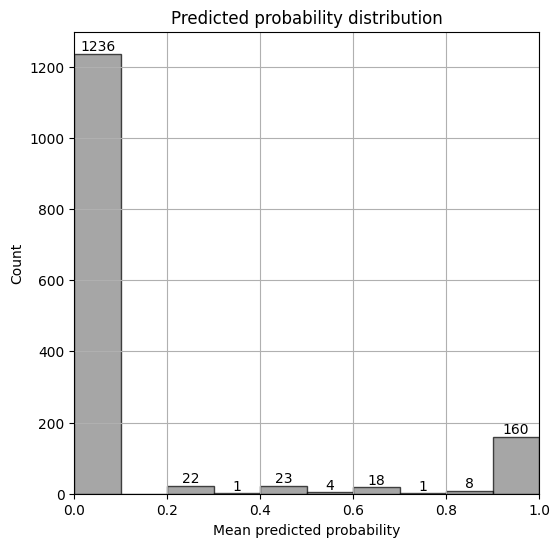

In [347]:
# The histogram of probability distribution (positive class)
bins = np.linspace(0.0, 1.0, 11)
counts, bin_edges = np.histogram(p_test_calibrated[:, 1], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
plt.figure(figsize=(6,6))
plt.hist(p_test_calibrated[:, 1], bins=bins, color='gray', edgecolor="black", alpha=0.7)
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bin_centers[i], counts[i] + 1, str(counts[i]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Mean predicted probability")
plt.ylabel("Count")
plt.title("Predicted probability distribution")
plt.xlim(0, 1)
plt.grid(True)
plt.show()

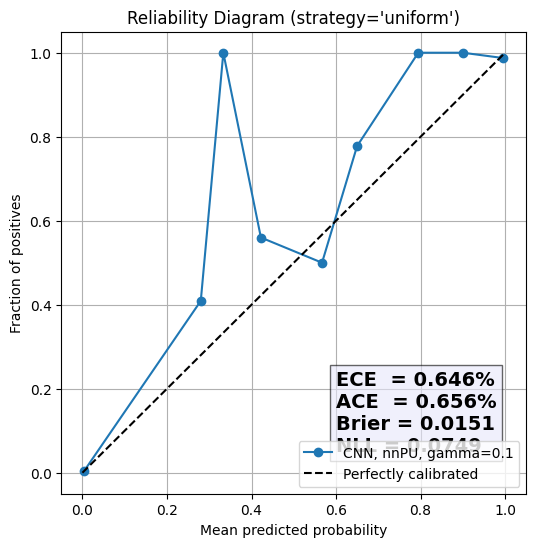

In [348]:
# strategy='uniform' -> equal-width binning
ece = expected_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
brier = brier_score_loss(y_test, p_test_calibrated[:, 1])
ace = adaptive_calibration_error(p_test_calibrated, y_test, n_bins=n_bins)
nll = F.cross_entropy(logits_test, torch.tensor(y_test, dtype=torch.long)).item()

prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='uniform')
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, nnPU, gamma=0.1')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'uniform\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

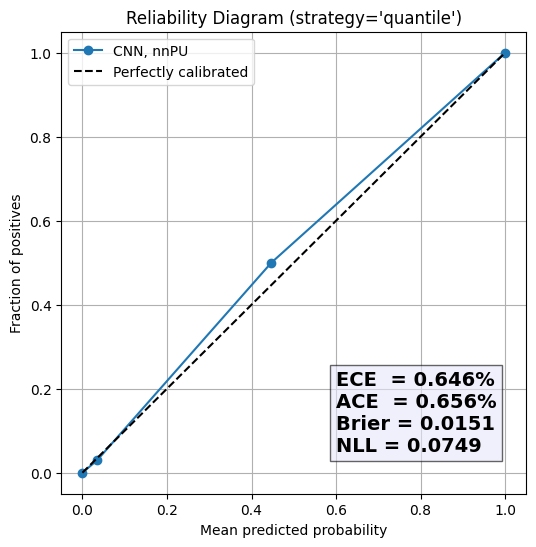

In [349]:
prob_true, prob_pred = calibration_curve(y_test, p_test_calibrated[:, 1], n_bins=10, strategy='quantile')
# There are very few samples in the bins in the middle
plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN, nnPU')
plt.plot([0,1], [0,1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Reliability Diagram (strategy=\'quantile\')')
plt.legend()
plt.grid()
plt.text(0.60, 0.05,
         f"ECE  = {ece*100:.3f}%\nACE  = {ace*100:.3f}%\nBrier = {brier:.4f}\nNLL = {nll:.4f}",
         fontsize=14, color='black', weight='bold',
         bbox=dict(facecolor='lavender', alpha=0.6, edgecolor='black'))
plt.show()

In [350]:
ece, ece_rows = ece_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ECE = {ece:.5f}")
print("bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error")
print("----+-------+--------------------+-------------+------------+--------------+----------------")
for i, n, lo, hi, conf, acc, diff, weighted in ece_rows:
    print(f"{i:2d}  | {n:5d} | [{lo:7.3f}, {hi:7.3f}] | {conf:10.3f}  | {acc:10.3f} |"
          f"  {diff:10.3f}  |  {weighted:10.5f}")

ECE = 0.00646
bin |   n   |      [lo, hi]      |  conf_mean  |  acc_mean  |  |acc-conf|  |  weighted_error
----+-------+--------------------+-------------+------------+--------------+----------------
 4  |     2 | [  0.400,   0.500] |      0.500  |      0.000 |       0.500  |     0.00068
 5  |    10 | [  0.500,   0.600] |      0.558  |      0.300 |       0.258  |     0.00175
 6  |    34 | [  0.600,   0.700] |      0.628  |      0.676 |       0.048  |     0.00111
 7  |    23 | [  0.700,   0.800] |      0.723  |      0.609 |       0.115  |     0.00179
 8  |     8 | [  0.800,   0.900] |      0.900  |      1.000 |       0.100  |     0.00054
 9  |  1396 | [  0.900,   1.000] |      0.996  |      0.996 |       0.001  |     0.00059


In [351]:
ace, ace_rows = ace_breakdown(y_test, p_test_calibrated, n_bins=10)
print(f"ACE = {ace:.5f}\n")

# Pretty printing grouped by class
for k in sorted(set(r[0] for r in ace_rows)):
    print(f"Class {k}:")
    print("bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|")
    print("----+-------+--------------------+------------+----------+-----------")
    for _, r, count, lo, hi, conf, acc, diff in [row for row in ace_rows if row[0] == k]:
        print(f"{r:2d}  | {count:5d} | [{lo:6.5f}, {hi:6.5f}] |"
              f"   {conf:6.3f}   |  {acc:6.3f}  |   {diff:6.3f}")
    print()

ACE = 0.00656

Class 0:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  |   148 | [0.00000, 0.02564] |    0.004   |   0.007  |    0.003
 1  |   148 | [0.02564, 0.96552] |    0.644   |   0.581  |    0.063
 2  |   148 | [0.96552, 1.00000] |    0.993   |   0.993  |    0.001
 3  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 4  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 5  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 6  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 7  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 8  |   148 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000
 9  |   141 | [1.00000, 1.00000] |    1.000   |   1.000  |    0.000

Class 1:
bin |   n   | conf_range         | conf_mean  | acc_mean | |acc-conf|
----+-------+--------------------+------------+----------+-----------
 0  | 

# Calibration Metrics

### **Expected Calibration Error (ECE)**

Let the predictions be divided into $M$ equally spaced bins $B_1, B_2, \dots, B_M$.
.  
The Expected Calibration Error measures the weighted average gap between accuracy and confidence across bins:

$$
\mathrm{ECE} = \sum_{m=1}^{M} \frac{|B_m|}{N} \, \big| \mathrm{acc}(B_m) - \mathrm{conf}(B_m) \big|
$$

where:

$$
\mathrm{acc}(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} \mathbb{1}(\hat{y}_i = y_i), \quad
\mathrm{conf}(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} \hat{p}_i
$$


---

### **Adaptive Calibration Error (ACE)**

ACE measures the average calibration error across all classes and adaptive (equal-frequency) ranges.  
For each class $k \in \{1, \dots, K\}$, the predicted probabilities $\pi_k(x_i)$ are sorted and divided into $R$ ranges such that each contains approximately the same number of samples.

$$
\mathrm{ACE} = \frac{1}{K R} \sum_{k=1}^{K} \sum_{r=1}^{R}
\big| \mathrm{acc}(r, k) - \mathrm{conf}(r, k) \big|
$$

where

$$
\mathrm{acc}(r, k) = \frac{1}{|B^{(k)}_r|} \sum_{i \in B^{(k)}_r} \mathbf{1}[y_i = k],
\quad
\mathrm{conf}(r, k) = \frac{1}{|B^{(k)}_r|} \sum_{i \in B^{(k)}_r} \pi_k(x_i)
$$

and each $B^{(k)}_r$ represents the $r$-th adaptive bin for class $k$.

---

### **Brier Score**

Measures the mean squared error between predicted probabilities and true binary outcomes:

$$
\mathrm{Brier} = \frac{1}{N} \sum_{i=1}^{N} \big( \hat{p}_i - y_i \big)^2
$$


---

### **Negative Log-Likelihood (NLL)**

Measures the average negative log-probability assigned to the true class:

$$
\mathrm{NLL} = -\frac{1}{N} \sum_{i=1}^{N} 
\Big[
y_i \log(\hat{p}_i) + (1 - y_i)\log(1 - \hat{p}_i)
\Big]
$$

Lower NLL indicates both better calibration and accuracy.